Во всех моделях модуль перехода от нейтрального класса установлен на уровне 0.5, предполагается, что изменение это параметра может сильно повлиять на обучение и, следовательно, предсказания моделей

# **Уставнока и импорт всего нужного**

In [1]:
!pip3 install tensorflow_text>=2.0.0rc0

In [2]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.1 MB/s eta 0:00:00


In [31]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text
import time
import numpy as np
from transformers import AutoTokenizer, AutoModel
import re
from collections import Counter
import seaborn as sns

# **Подготовка к обучению**

In [4]:
data_ru = pd.read_csv('/content/drive/MyDrive/Sentiment_Course_Work/RuReviews_w_USE-M.csv')
data_ru.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
# data_ru

In [5]:
data_ru2 = pd.read_csv('/content/drive/MyDrive/Sentiment_Course_Work/RuReviews_w_tiny2.csv')
data_ru2.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [6]:
def take_num(row):
  arr = np.fromstring(row[2:-2].replace('\n', ' '), sep=' ')
  return arr

def take_num_from_tiny(row):
  arr = np.fromstring(row[1:-1].replace('\n', ' '), sep=' ')
  return arr

In [9]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [10]:
yandex = pd.read_csv('/content/drive/MyDrive/Sentiment_Course_Work/attr_parcer_w_dost_trans')
yandex['USE_M'] = yandex['review'].apply(lambda x: embed(x).numpy())
yandex['Siuu'] = yandex['simple_sent_02'].apply(lambda x: -1 if x == 2 else x)

In [11]:
yandex.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [12]:
yandex['USE_M'] = yandex['USE_M'].apply(lambda x: x[0])

In [13]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model_tiny2 = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# data_ru['USE_M'] = data_ru['review'].apply(lambda x: embed(x).numpy()[0])
data_ru['USE_M'] = data_ru['USE_M'].apply(lambda x: take_num(x))
data_ru['USE_M'] = data_ru['USE_M'].apply(lambda x: x.astype(np.float32))
data_ru['sentiment_int'] = data_ru['sentiment_int'].apply(lambda x: -1 if x == 2 else x)

In [15]:
# data_ru['tiny2'] = data_ru['review'].apply(lambda x: embed_bert_cls(x, model_tiny2, tokenizer))
data_ru2['tiny2'] = data_ru2['tiny2'].apply(lambda x: take_num_from_tiny(x).astype(np.float32))
data_ru2['sentiment_int'] = data_ru2['sentiment_int'].apply(lambda x: -1 if x == 2 else x)

In [16]:
yandex['tiny2'] = yandex['review'].apply(lambda x: embed_bert_cls(x, model_tiny2, tokenizer))

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_size=512, hidden_size=128):
        super(SentimentClassifier, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Linear(512, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        lstm_out, _ = self.lstm(embedded)
        # last_lstm_out = lstm_out[:, -1]
        fc_out = self.fc(lstm_out)
        sentiment = torch.tanh(fc_out).squeeze()
        return sentiment


class SentimentClassifierTiny128(nn.Module):
    def __init__(self, embedding_size=312, hidden_size=128):
        super(SentimentClassifierTiny128, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Linear(312, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        lstm_out, _ = self.lstm(embedded)
        fc_out = self.fc(lstm_out)
        sentiment = torch.tanh(fc_out).squeeze()
        return sentiment

In [24]:
class SentimentClassifier256(nn.Module):
    def __init__(self, embedding_size=512, hidden_size=256):
        super(SentimentClassifier256, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Linear(512, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        lstm_out, _ = self.lstm(embedded)
        # last_lstm_out = lstm_out[:, -1]
        fc_out = self.fc(lstm_out)
        sentiment = torch.tanh(fc_out).squeeze()
        return sentiment


class SentimentClassifierTiny256(nn.Module):
    def __init__(self, embedding_size=312, hidden_size=256):
        super(SentimentClassifierTiny256, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Linear(312, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        lstm_out, _ = self.lstm(embedded)
        fc_out = self.fc(lstm_out)
        sentiment = torch.tanh(fc_out).squeeze()
        return sentiment

In [25]:
class SentimentClassifier64(nn.Module):
    def __init__(self, embedding_size=512, hidden_size=64):
        super(SentimentClassifier64, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Linear(512, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        lstm_out, _ = self.lstm(embedded)
        # last_lstm_out = lstm_out[:, -1]
        fc_out = self.fc(lstm_out)
        sentiment = torch.tanh(fc_out).squeeze()
        return sentiment


class SentimentClassifierTiny64(nn.Module):
    def __init__(self, embedding_size=312, hidden_size=64):
        super(SentimentClassifierTiny64, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Linear(312, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        lstm_out, _ = self.lstm(embedded)
        fc_out = self.fc(lstm_out)
        sentiment = torch.tanh(fc_out).squeeze()
        return sentiment

In [35]:
def metric(df: pd.DataFrame, embed_name: str, target_name: str, probability, batch_size=32) -> None:

  def proba(x):
    if x >= probability:
      return 1
    elif x < probability:
      return -1
    return 0

  inputs = torch.tensor(df[f'{embed_name}'].to_list())
  targets = torch.tensor(df[f'{target_name}'].to_list())
  dataset = TensorDataset(inputs, targets)

  val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  model.eval()
  val_loss = 0
  y_true, y_pred = [], []
  with torch.no_grad():
    for inputs, targets in val_loader:
      outputs = model(inputs)
      y_true += targets.tolist()
      y_pred += outputs.tolist()

  y_pred = list(map(proba, y_pred))

  print('Accuracy: ', accuracy_score(y_true, y_pred))
  f1 = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted', zero_division=True)
  recall = recall_score(y_true, y_pred, average='weighted')
  print(f'F1: {f1}, Precision: {precision}, Recall: {recall}')

  f1 = f1_score(y_true, y_pred, average='macro')
  precision = precision_score(y_true, y_pred, average='macro', zero_division=True)
  recall = recall_score(y_true, y_pred, average='macro')
  print(f'F1: {f1}, Precision: {precision}, Recall: {recall}', '\n')

  print(classification_report(y_true, y_pred))
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Reds", fmt="d")

  return y_pred

In [ ]:
def train_model(num_epochs, batch_size, learning_rate, model_in, criterion_in, flag, df=None, embed_name=None, target_name=None):

  def proba(x):
    if x > 0.5:
      return 1
    elif x < -0.5:
      return -1
    return 0

  # model = SentimentClassifier()
  model = model_in

# Загружаем данные и создаём DataLoader
  if flag:
    inputs = torch.tensor(data_ru['USE_M'].apply(lambda x: x[0]).to_list())
    targets = torch.tensor(data_ru['sentiment_int'].apply(lambda x: -1 if x == 2 else x).to_list())
  else:
    inputs = torch.tensor(df[f'{embed_name}'].to_list())
    targets = torch.tensor(df[f'{target_name}'].to_list())
  dataset = TensorDataset(inputs, targets)

# Разбиваем на обучающую и валидационную выборки
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Определяем функцию потерь и оптимизатор
  # criterion = nn.CrossEntropyLoss()
  criterion = criterion_in
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Процесс обучения
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Train Epoch: {epoch+1}, Loss: {train_loss}')

    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
      for inputs, targets in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, targets.float()).item()
        y_true += targets.tolist()
        y_pred += outputs.tolist()
    y_proba = y_pred
    y_pred = list(map(proba, y_pred))

    val_loss /= len(val_loader)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Val Epoch: {epoch+1}, F1: {f1}, Precision: {precision}, Recall: {recall}')

    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Val Epoch: {epoch+1}, F1: {f1}, Precision: {precision}, Recall: {recall}', '\n')

  return model, y_pred, y_proba

In [21]:
def train_model_2(num_epochs, batch_size, learning_rate, model_in, criterion_in, flag, probability, df=None, embed_name=None, target_name=None):

  def proba(x):
    if x > probability:
      return 1
    elif x < -probability:
      return -1
    return 0

  # model = SentimentClassifier()
  model = model_in

# Загружаем данные и создаём DataLoader
  if flag:
    inputs = torch.tensor(data_ru['USE_M'].apply(lambda x: x[0]).to_list())
    targets = torch.tensor(data_ru['sentiment_int'].apply(lambda x: -1 if x == 2 else x).to_list())
  else:
    inputs = torch.tensor(df[f'{embed_name}'].to_list())
    targets = torch.tensor(df[f'{target_name}'].to_list())
  dataset = TensorDataset(inputs, targets)

# Разбиваем на обучающую и валидационную выборки
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Определяем функцию потерь и оптимизатор
  # criterion = nn.CrossEntropyLoss()
  criterion = criterion_in
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Процесс обучения
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Train Epoch: {epoch+1}, Loss: {train_loss}')

    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
      for inputs, targets in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, targets.float()).item()
        y_true += targets.tolist()
        y_pred += outputs.tolist()
    y_proba = y_pred
    y_pred = list(map(proba, y_pred))

    val_loss /= len(val_loader)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Val Epoch: {epoch+1}, F1: {f1}, Precision: {precision}, Recall: {recall}')

    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Val Epoch: {epoch+1}, F1: {f1}, Precision: {precision}, Recall: {recall}', '\n')

  return model, y_pred, y_proba

# **Обучение на USE-M 128 нейронов**
Модуль перехода от нейтрольного: 0.5

In [ ]:
model, y_pred, y_proba = train_model(5, 32, 0.001, SentimentClassifier(), nn.CrossEntropyLoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -16.387410112486947
Val Epoch: 1, F1: 0.5055819328517601, Precision: 0.6239559472439, Recall: 0.614
Val Epoch: 1, F1: 0.502982893367916, Precision: 0.6243623477057608, Recall: 0.6101141406702771 

Train Epoch: 2, Loss: -16.790758167796664
Val Epoch: 2, F1: 0.49996435462551847, Precision: 0.6489369066438121, Recall: 0.6132222222222222
Val Epoch: 2, F1: 0.49728300020028166, Precision: 0.6496627959825654, Recall: 0.6094799512853093 

Train Epoch: 3, Loss: -16.745902434666952
Val Epoch: 3, F1: 0.49050466689768424, Precision: 0.6358965818797723, Recall: 0.6078333333333333
Val Epoch: 3, F1: 0.48773773245725516, Precision: 0.6364461716047184, Recall: 0.6042550840594266 

Train Epoch: 4, Loss: -16.87782474782732
Val Epoch: 4, F1: 0.4969431028367558, Precision: 0.6002657219695595, Recall: 0.612
Val Epoch: 4, F1: 0.4942404970146659, Precision: 0.6004080923889972, Recall: 0.608155386661701 

Train Epoch: 5, Loss: -16.782940459357366
Val Epoch: 5, F1: 0.49520563050208016, Pre

In [ ]:
y_pred_yand_01 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

Accuracy:  0.9086142322097378
F1: 0.9086142322097378, Precision: 0.9086142322097378, Recall: 0.9086142322097378
F1: 0.7074766153713522, Precision: 0.7074766153713522, Recall: 0.7074766153713522 



Тестируем еще раз, странные метрики вышли

In [ ]:
model, y_pred, y_proba = train_model(5, 32, 0.001, SentimentClassifier(), nn.CrossEntropyLoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -16.610793191274006
Val Epoch: 1, F1: 0.49853743976338694, Precision: 0.5898545116569166, Recall: 0.6108888888888889
Val Epoch: 1, F1: 0.4988628305437171, Precision: 0.5898029701114933, Recall: 0.6114097124233417 

Train Epoch: 2, Loss: -16.986919243282742
Val Epoch: 2, F1: 0.49683048458807105, Precision: 0.6094320268038517, Recall: 0.612
Val Epoch: 2, F1: 0.4971628415877367, Precision: 0.6093486700085505, Recall: 0.6125329904698849 

Train Epoch: 3, Loss: -16.758835270457798
Val Epoch: 3, F1: 0.4960698803693225, Precision: 0.6163728915474451, Recall: 0.6102777777777778
Val Epoch: 3, F1: 0.496410758600392, Precision: 0.6162987130365097, Recall: 0.6107730396146761 

Train Epoch: 4, Loss: -17.032028708881803
Val Epoch: 4, F1: 0.4857495103689954, Precision: 0.5663590846128492, Recall: 0.5957777777777777
Val Epoch: 4, F1: 0.48606598271677104, Precision: 0.5663078981394604, Recall: 0.5963540347508244 

Train Epoch: 5, Loss: -17.122313691457112
Val Epoch: 5, F1: 0.49006

In [ ]:
y_pred_yand_01 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

Accuracy:  0.8925093632958802
F1: 0.8995619499665797, Precision: 0.9088442955481446, Recall: 0.8925093632958802
F1: 0.7019109766890019, Precision: 0.6799484727221097, Recall: 0.734460537092116 



In [ ]:
y_pred_yand_01 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

Accuracy:  0.8895131086142322
F1: 0.8990432317668621, Precision: 0.9127670689766743, Recall: 0.8895131086142322
F1: 0.7089559105062981, Precision: 0.6808559507674552, Recall: 0.7566813224707961 



In [ ]:
yandex['model_1'] = y_pred_yand_01
yandex[(yandex['model_1'] == yandex['Siuu']) & (yandex['model_1'] == -1)]

In [ ]:
yandex[(1 == yandex['Siuu']) & (yandex['model_1'] == -1)]

In [ ]:
yandex[(yandex['model_1'] == -1)]

In [ ]:
Counter(yandex[(1 == yandex['Siuu']) & (yandex['model_1'] == -1)]['rating'])

Counter({5.0: 103, 4.0: 19})

In [ ]:
yandex[(1 == yandex['Siuu']) & (yandex['model_1'] == -1)]['review'].to_list() #модель обращает внимание на -не- (знак усиления хорошего), а также верно находит отзывы, где люди перечисляют недостатки

In [ ]:
model, y_pred, y_proba = train_model(10, 64, 0.0001, SentimentClassifier(), nn.CrossEntropyLoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -30.313534898546006
Val Epoch: 1, F1: 0.5517182977160112, Precision: 0.6235852441104923, Recall: 0.6288333333333334
Val Epoch: 1, F1: 0.5530780825828175, Precision: 0.623508608883257, Recall: 0.6309360641029561 

Train Epoch: 2, Loss: -35.23008938047621
Val Epoch: 2, F1: 0.5348268426595817, Precision: 0.6211472521326257, Recall: 0.6231666666666666
Val Epoch: 2, F1: 0.5363025658403543, Precision: 0.6210444175222962, Recall: 0.6254242887747335 

Train Epoch: 3, Loss: -35.563199412875704
Val Epoch: 3, F1: 0.5277206701105813, Precision: 0.6118828090766464, Recall: 0.6215555555555555
Val Epoch: 3, F1: 0.5292544069753872, Precision: 0.6118407931954705, Recall: 0.6237792417348961 

Train Epoch: 4, Loss: -35.789733823776245
Val Epoch: 4, F1: 0.5239946253391791, Precision: 0.6226685999789128, Recall: 0.6216666666666667
Val Epoch: 4, F1: 0.5255608234759674, Precision: 0.6225321733630689, Recall: 0.6239415730002797 

Train Epoch: 5, Loss: -35.86480055279202
Val Epoch: 5, F1:

In [ ]:
y_pred_yand_02 = metric(yandex, 'USE_M', 'Siuu', 0, 64)

Accuracy:  0.8715355805243445
F1: 0.885724861190651, Precision: 0.9068911773622189, Recall: 0.8715355805243445
F1: 0.6830470070280565, Precision: 0.6543837857523681, Recall: 0.7428768481400061 



In [ ]:
model, y_pred, y_proba = train_model(5, 16, 0.001, SentimentClassifier(), nn.CrossEntropyLoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -8.100625593158934
Val Epoch: 1, F1: 0.5023947728123419, Precision: 0.6229377070936446, Recall: 0.6153333333333333
Val Epoch: 1, F1: 0.49751881072620163, Precision: 0.6221009516648804, Recall: 0.6099732301913405 

Train Epoch: 2, Loss: -8.215516593191358
Val Epoch: 2, F1: 0.5003177390846414, Precision: 0.5813475438963893, Recall: 0.6121111111111112
Val Epoch: 2, F1: 0.4953754475293148, Precision: 0.579543049162279, Recall: 0.606883557859207 

Train Epoch: 3, Loss: -8.23685268190172
Val Epoch: 3, F1: 0.49986035200444157, Precision: 0.5764808584104975, Recall: 0.6155555555555555
Val Epoch: 3, F1: 0.4949233463527533, Precision: 0.5748387608398035, Recall: 0.610085757715127 

Train Epoch: 4, Loss: -8.242860329018699
Val Epoch: 4, F1: 0.49898387130480093, Precision: 0.5921057412425712, Recall: 0.6111111111111112
Val Epoch: 4, F1: 0.4939411872470442, Precision: 0.5902463669414851, Recall: 0.6059880296687765 

Train Epoch: 5, Loss: -8.367363951100243
Val Epoch: 5, F1: 0.

In [ ]:
y_pred_yand_03 = metric(yandex, 'USE_M', 'Siuu', 0, 16)

Accuracy:  0.8453183520599251
F1: 0.8690030329221341, Precision: 0.9088233902450185, Recall: 0.8453183520599251
F1: 0.6665401625401626, Precision: 0.6373945204732105, Recall: 0.7623442820811241 



In [ ]:
model, y_pred, y_proba = train_model(10, 64, 0.0001, SentimentClassifier(), nn.MSELoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.3103861889176899
Val Epoch: 1, F1: 0.7012993414594216, Precision: 0.7169594637266737, Recall: 0.6963888888888888
Val Epoch: 1, F1: 0.7011420555815104, Precision: 0.7168600899281031, Recall: 0.6961788487890991 

Train Epoch: 2, Loss: 0.2571881529622608
Val Epoch: 2, F1: 0.7102451542262453, Precision: 0.7224977610419561, Recall: 0.7046666666666667
Val Epoch: 2, F1: 0.7101282544364076, Precision: 0.7223559199811778, Recall: 0.7045644459308544 

Train Epoch: 3, Loss: 0.25005732435650296
Val Epoch: 3, F1: 0.7165429150520914, Precision: 0.7282285829548167, Recall: 0.7127222222222223
Val Epoch: 3, F1: 0.7163975714066959, Precision: 0.7281469007911889, Recall: 0.7125196723687622 

Train Epoch: 4, Loss: 0.2457407810224427
Val Epoch: 4, F1: 0.7150441179670326, Precision: 0.7332059274123676, Recall: 0.709
Val Epoch: 4, F1: 0.7149130158707767, Precision: 0.7330917887630187, Recall: 0.7088456618290809 

Train Epoch: 5, Loss: 0.243045455329948
Val Epoch: 5, F1: 0.718407222166

In [ ]:
y_pred_yand_04 = metric(yandex, 'USE_M', 'Siuu', 0, 64)

Accuracy:  0.8629213483146068
F1: 0.8811186192085066, Precision: 0.9105617810176958, Recall: 0.8629213483146068
F1: 0.6836247086247086, Precision: 0.6520423741435806, Recall: 0.7640146126988232 



In [ ]:
model, y_pred, y_proba = train_model(7, 32, 0.001, SentimentClassifier(), nn.MSELoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2624898162815306
Val Epoch: 1, F1: 0.7096267111933178, Precision: 0.7513488322636873, Recall: 0.7026111111111111
Val Epoch: 1, F1: 0.709272098186091, Precision: 0.7503920402803411, Recall: 0.7029272662903158 

Train Epoch: 2, Loss: 0.24504341582291655
Val Epoch: 2, F1: 0.7178153187545657, Precision: 0.7464450545421843, Recall: 0.71
Val Epoch: 2, F1: 0.7174214365269339, Precision: 0.7455457001405174, Recall: 0.7101381336933801 

Train Epoch: 3, Loss: 0.24009857367806964
Val Epoch: 3, F1: 0.719240166678329, Precision: 0.7539575897028775, Recall: 0.7136111111111111
Val Epoch: 3, F1: 0.7188721217992913, Precision: 0.7530653559264681, Recall: 0.7138345705283079 

Train Epoch: 4, Loss: 0.23600269466638565
Val Epoch: 4, F1: 0.7238492411820364, Precision: 0.7540063034040345, Recall: 0.7167777777777777
Val Epoch: 4, F1: 0.7234747573241481, Precision: 0.7531161798835767, Recall: 0.7169647421354783 

Train Epoch: 5, Loss: 0.23231569450596967
Val Epoch: 5, F1: 0.72550910278

In [ ]:
y_pred_yand_05 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

Accuracy:  0.8434456928838951
F1: 0.8665039638406066, Precision: 0.903458761654315, Recall: 0.8434456928838951
F1: 0.6555493692201144, Precision: 0.6289361702127659, Recall: 0.7394499762920816 



In [ ]:
model, y_pred, y_proba = train_model(5, 16, 0.001, SentimentClassifier(), nn.MSELoss(), False, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.26171039003713265
Val Epoch: 1, F1: 0.7185974822132902, Precision: 0.7326413402471155, Recall: 0.7126111111111111
Val Epoch: 1, F1: 0.7186718932581954, Precision: 0.7327195334086826, Recall: 0.7127067076697092 

Train Epoch: 2, Loss: 0.24485589824534124
Val Epoch: 2, F1: 0.716632594187205, Precision: 0.7430766084840672, Recall: 0.7127222222222223
Val Epoch: 2, F1: 0.7168386702687878, Precision: 0.7429751569993742, Recall: 0.7131985473820196 

Train Epoch: 3, Loss: 0.23961941897372405
Val Epoch: 3, F1: 0.729157364286478, Precision: 0.7389080808551856, Recall: 0.7249444444444444
Val Epoch: 3, F1: 0.7292614837333417, Precision: 0.7389371392138608, Recall: 0.7251308064844078 

Train Epoch: 4, Loss: 0.23549537051551872
Val Epoch: 4, F1: 0.7248650750382614, Precision: 0.7441277535851942, Recall: 0.7199444444444445
Val Epoch: 4, F1: 0.725013209047245, Precision: 0.7440813388409153, Recall: 0.7202811835668393 

Train Epoch: 5, Loss: 0.23095311892115408
Val Epoch: 5, F1:

In [ ]:
y_pred_yand_06 = metric(yandex, 'USE_M', 'Siuu', 0, 16)

Accuracy:  0.8468164794007491
F1: 0.8701697099212451, Precision: 0.9095567564300787, Recall: 0.8468164794007491
F1: 0.6689866267602411, Precision: 0.639309726580009, Recall: 0.7651515151515151 



# **Обучение на rubert-tiny2 128 нейронов**
Модуль перехода от нейтрольного: 0.5

In [ ]:
model, y_pred, y_proba = train_model(10, 64, 0.0001, SentimentClassifierTiny128(), nn.CrossEntropyLoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -27.064986375808715
Val Epoch: 1, F1: 0.5483189667688482, Precision: 0.5994087162100867, Recall: 0.6172777777777778
Val Epoch: 1, F1: 0.5501945390310632, Precision: 0.6003829184097631, Recall: 0.6191858996959778 

Train Epoch: 2, Loss: -32.6088592859904
Val Epoch: 2, F1: 0.5312203201643256, Precision: 0.5967307672885171, Recall: 0.6136666666666667
Val Epoch: 2, F1: 0.53325968580529, Precision: 0.597759280229135, Recall: 0.6156166907646781 

Train Epoch: 3, Loss: -32.97888502714369
Val Epoch: 3, F1: 0.526946687680029, Precision: 0.5982303028691532, Recall: 0.6137222222222222
Val Epoch: 3, F1: 0.5290207718072957, Precision: 0.5991813889929049, Recall: 0.6157803426348595 

Train Epoch: 4, Loss: -33.280360819498696
Val Epoch: 4, F1: 0.520150380788432, Precision: 0.5921644262551438, Recall: 0.6112222222222222
Val Epoch: 4, F1: 0.5222576618788747, Precision: 0.5930890371590318, Recall: 0.6133705706761562 

Train Epoch: 5, Loss: -33.31402715237935
Val Epoch: 5, F1: 0.515

In [ ]:
y_pred_yand_07 = metric(yandex, 'tiny2', 'Siuu', 0, 64)

Accuracy:  0.8247191011235955
F1: 0.8546226806077709, Precision: 0.9062401858916808, Recall: 0.8247191011235955
F1: 0.6464260611802096, Precision: 0.6224545228782516, Recall: 0.7550594853226432 



In [ ]:
model, y_pred, y_proba = train_model(7, 32, 0.001, SentimentClassifierTiny128(), nn.CrossEntropyLoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -15.897683499336242
Val Epoch: 1, F1: 0.5021661494834121, Precision: 0.6151844440634486, Recall: 0.6058888888888889
Val Epoch: 1, F1: 0.4981318723238998, Precision: 0.6150310015504467, Recall: 0.6008339750431668 

Train Epoch: 2, Loss: -16.401563569492765
Val Epoch: 2, F1: 0.47904100708082753, Precision: 0.5811971905214339, Recall: 0.5888888888888889
Val Epoch: 2, F1: 0.47506532399790485, Precision: 0.5810300425830687, Recall: 0.5838224094373813 

Train Epoch: 3, Loss: -16.374713335990904
Val Epoch: 3, F1: 0.4936072631170198, Precision: 0.5911616952485709, Recall: 0.6015555555555555
Val Epoch: 3, F1: 0.48938128240276974, Precision: 0.5903473370422282, Recall: 0.5964280545314967 

Train Epoch: 4, Loss: -16.445261312802632
Val Epoch: 4, F1: 0.48536465890667263, Precision: 0.598800791318754, Recall: 0.6004444444444444
Val Epoch: 4, F1: 0.4812201770126389, Precision: 0.5987625519397268, Recall: 0.5952534085949237 

Train Epoch: 5, Loss: -16.30988552040524
Val Epoch: 5

In [ ]:
y_pred_yand_08 = metric(yandex, 'tiny2', 'Siuu', 0, 32)

Accuracy:  0.8588014981273409
F1: 0.8780599244248471, Precision: 0.9092311581984053, Recall: 0.8588014981273409
F1: 0.6778807891071038, Precision: 0.6471389812093523, Recall: 0.7597741281951809 



In [ ]:
model, y_pred, y_proba = train_model(5, 16, 0.001, SentimentClassifierTiny128(), nn.CrossEntropyLoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -7.805816029787064
Val Epoch: 1, F1: 0.4937444793059098, Precision: 0.595324383551464, Recall: 0.6037777777777777
Val Epoch: 1, F1: 0.49146132069078785, Precision: 0.5951080580245859, Recall: 0.6009516092357851 

Train Epoch: 2, Loss: -7.977504091819127
Val Epoch: 2, F1: 0.4875741891228486, Precision: 0.5566830110632782, Recall: 0.5968333333333333
Val Epoch: 2, F1: 0.48517006209150343, Precision: 0.5557937120158581, Recall: 0.5941516460429669 

Train Epoch: 3, Loss: -8.012860402001275
Val Epoch: 3, F1: 0.48204315196052294, Precision: 0.5952632120427584, Recall: 0.5925
Val Epoch: 3, F1: 0.47983146575108515, Precision: 0.5952821018595995, Recall: 0.5896095892301885 

Train Epoch: 4, Loss: -7.998285965813531
Val Epoch: 4, F1: 0.4831469249604908, Precision: 0.6094382977615164, Recall: 0.5969444444444445
Val Epoch: 4, F1: 0.4808554342373122, Precision: 0.6094921851595175, Recall: 0.5940579502155153 

Train Epoch: 5, Loss: -8.010353307724
Val Epoch: 5, F1: 0.48902093457

In [ ]:
y_pred_yand_09 = metric(yandex, 'tiny2', 'Siuu', 0, 16)

Accuracy:  0.7902621722846442
F1: 0.8316416982263317, Precision: 0.9106479734396328, Recall: 0.7902621722846442
F1: 0.6271455588627242, Precision: 0.6131768085321052, Recall: 0.7739988792620371 



In [ ]:
model, y_pred, y_proba = train_model(15, 128, 0.0001, SentimentClassifierTiny128(), nn.MSELoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.38310057906761474
Val Epoch: 1, F1: 0.6663604787238777, Precision: 0.6916376004968301, Recall: 0.6580555555555555
Val Epoch: 1, F1: 0.6662310220653582, Precision: 0.6913977991732986, Recall: 0.6580337704464979 

Train Epoch: 2, Loss: 0.2941274436233734
Val Epoch: 2, F1: 0.6744253772195635, Precision: 0.6958510625841892, Recall: 0.6673333333333333
Val Epoch: 2, F1: 0.6742911722663862, Precision: 0.6956332721863537, Recall: 0.6672876276830483 

Train Epoch: 3, Loss: 0.28706408184862053
Val Epoch: 3, F1: 0.6786006673453007, Precision: 0.7013758015695114, Recall: 0.6712777777777778
Val Epoch: 3, F1: 0.6784699284837036, Precision: 0.701154836913032, Recall: 0.6712413717624791 

Train Epoch: 4, Loss: 0.2821189224667066
Val Epoch: 4, F1: 0.6844561948268196, Precision: 0.7037755140278362, Recall: 0.6781111111111111
Val Epoch: 4, F1: 0.6843179367938689, Precision: 0.703564578956852, Recall: 0.6780523609257739 

Train Epoch: 5, Loss: 0.2779455920730984
Val Epoch: 5, F1: 0

In [ ]:
y_pred_yand_10 = metric(yandex, 'tiny2', 'Siuu', 0, 128)

Accuracy:  0.8078651685393259
F1: 0.8442230625839401, Precision: 0.9128629708226494, Recall: 0.8078651685393259
F1: 0.6434839667864936, Precision: 0.62300619494325, Recall: 0.7836221388852969 



In [ ]:
model, y_pred, y_proba = train_model(10, 64, 0.0001, SentimentClassifierTiny128(), nn.MSELoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.34595722949504853
Val Epoch: 1, F1: 0.6648575275212423, Precision: 0.6900271622826563, Recall: 0.6580555555555555
Val Epoch: 1, F1: 0.6652289108113161, Precision: 0.6906538518309452, Recall: 0.6581404462225368 

Train Epoch: 2, Loss: 0.28730713154209986
Val Epoch: 2, F1: 0.6686292649802654, Precision: 0.6925976338488307, Recall: 0.6604444444444444
Val Epoch: 2, F1: 0.6689774783063321, Precision: 0.6932958800523377, Recall: 0.6604760381753801 

Train Epoch: 3, Loss: 0.27876037539376153
Val Epoch: 3, F1: 0.6827539946736189, Precision: 0.7065876218494601, Recall: 0.6768333333333333
Val Epoch: 3, F1: 0.683117670155629, Precision: 0.7071862725673969, Recall: 0.6769263214446323 

Train Epoch: 4, Loss: 0.2726854276392195
Val Epoch: 4, F1: 0.6881342918451436, Precision: 0.714644608714295, Recall: 0.6823333333333333
Val Epoch: 4, F1: 0.6884837311761222, Precision: 0.7152435645197169, Recall: 0.6823919846966423 

Train Epoch: 5, Loss: 0.26878042475382485
Val Epoch: 5, F1:

In [ ]:
y_pred_yand_11 = metric(yandex, 'tiny2', 'Siuu', 0, 64)

Accuracy:  0.8535580524344569
F1: 0.8754855232859361, Precision: 0.9131020470598161, Recall: 0.8535580524344569
F1: 0.6805159631848333, Precision: 0.6483823601109304, Recall: 0.7787781800939696 



In [ ]:
model, y_pred, y_proba = train_model(7, 32, 0.001, SentimentClassifierTiny128(), nn.MSELoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.28500119512610966
Val Epoch: 1, F1: 0.6884955979570901, Precision: 0.743331284847096, Recall: 0.6822777777777778
Val Epoch: 1, F1: 0.6882347519627322, Precision: 0.7426762316074095, Recall: 0.6824736482689756 

Train Epoch: 2, Loss: 0.2662058477335506
Val Epoch: 2, F1: 0.7070018184290702, Precision: 0.7272063520160574, Recall: 0.6998333333333333
Val Epoch: 2, F1: 0.7066890151707662, Precision: 0.7266059497733885, Recall: 0.6997952262900825 

Train Epoch: 3, Loss: 0.26064050036999914
Val Epoch: 3, F1: 0.7099366629966286, Precision: 0.7343050411329071, Recall: 0.7040555555555555
Val Epoch: 3, F1: 0.7096229176869105, Precision: 0.7337459403705789, Recall: 0.704019399580068 

Train Epoch: 4, Loss: 0.2560513831178347
Val Epoch: 4, F1: 0.6996574165205013, Precision: 0.7460005357729198, Recall: 0.6957222222222222
Val Epoch: 4, F1: 0.6993631664825152, Precision: 0.7454192185020373, Recall: 0.6957921355329432 

Train Epoch: 5, Loss: 0.2532705886446767
Val Epoch: 5, F1: 0

In [ ]:
y_pred_yand_12 = metric(yandex, 'tiny2', 'Siuu', 0, 32)

Accuracy:  0.8
F1: 0.8385366033289143, Precision: 0.9113583910319815, Recall: 0.8
F1: 0.6353936514950655, Precision: 0.6178494889548302, Recall: 0.7773341523341524 



In [ ]:
model, y_pred, y_proba = train_model(5, 16, 0.001, SentimentClassifierTiny128(), nn.MSELoss(), False, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2849881445392966
Val Epoch: 1, F1: 0.702950144426494, Precision: 0.7376675077971963, Recall: 0.6967777777777778
Val Epoch: 1, F1: 0.7032466827798493, Precision: 0.7377028354979361, Recall: 0.6973160915752311 

Train Epoch: 2, Loss: 0.26863214251688783
Val Epoch: 2, F1: 0.7016948936438717, Precision: 0.7471769456188239, Recall: 0.6954444444444444
Val Epoch: 2, F1: 0.7020235051579683, Precision: 0.7472014474463192, Recall: 0.6960484265969048 

Train Epoch: 3, Loss: 0.26229855637293725
Val Epoch: 3, F1: 0.6955561105587891, Precision: 0.7621616762187633, Recall: 0.6896666666666667
Val Epoch: 3, F1: 0.6959023079625709, Precision: 0.7621247632198909, Recall: 0.6903431976744696 

Train Epoch: 4, Loss: 0.25783026858170827
Val Epoch: 4, F1: 0.7018042260703329, Precision: 0.7408424838279543, Recall: 0.7008333333333333
Val Epoch: 4, F1: 0.7022643085673845, Precision: 0.7406172543193884, Recall: 0.701778391410013 

Train Epoch: 5, Loss: 0.2546433749463823
Val Epoch: 5, F1: 

In [ ]:
y_pred_yand_13 = metric(yandex, 'tiny2', 'Siuu', 0, 16)

Accuracy:  0.8456928838951311
F1: 0.8692689136454069, Precision: 0.9088926413208561, Recall: 0.8456928838951311
F1: 0.6669536816023427, Precision: 0.6377215891104779, Recall: 0.7625490322858743 



In [ ]:
yandex['model_2'] = y_pred_yand_02
yandex['model_3'] = y_pred_yand_03
yandex['model_4'] = y_pred_yand_04
yandex['model_5'] = y_pred_yand_05
yandex['model_6'] = y_pred_yand_06
yandex['model_7'] = y_pred_yand_07
yandex['model_8'] = y_pred_yand_08
yandex['model_9'] = y_pred_yand_09
yandex['model_10'] = y_pred_yand_10
yandex['model_11'] = y_pred_yand_11
yandex['model_12'] = y_pred_yand_12
yandex['model_13'] = y_pred_yand_13

In [ ]:
yandex.to_csv('YandexAttReviews_13Models.csv')

# **Обучение на USE-M 256 нейронов**

In [26]:
model, y_pred, y_proba = train_model_2(10, 128, 0.001, SentimentClassifier256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

<ipython-input-21-1d427e776e47>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  inputs = torch.tensor(df[f'{embed_name}'].to_list())


Train Epoch: 1, Loss: -66.96044995983794
Val Epoch: 1, F1: 0.5085050143438966, Precision: 0.6036490546301294, Recall: 0.6147777777777778
Val Epoch: 1, F1: 0.508024132675914, Precision: 0.6037180304177691, Recall: 0.6140784197856727 

Train Epoch: 2, Loss: -70.30698604143322
Val Epoch: 2, F1: 0.5037607549094973, Precision: 0.600803632186324, Recall: 0.6135
Val Epoch: 2, F1: 0.5032889851687791, Precision: 0.600915787989729, Recall: 0.6127296980461905 

Train Epoch: 3, Loss: -70.0878112709967
Val Epoch: 3, F1: 0.5036142489952798, Precision: 0.6125719627868647, Recall: 0.6118333333333333
Val Epoch: 3, F1: 0.5031591778244441, Precision: 0.6127432831914837, Recall: 0.6110244361109242 

Train Epoch: 4, Loss: -70.41229782646545
Val Epoch: 4, F1: 0.501032538686713, Precision: 0.6135476962448945, Recall: 0.6145
Val Epoch: 4, F1: 0.5005460296922566, Precision: 0.6136826680892428, Recall: 0.6137317113727686 

Train Epoch: 5, Loss: -70.46026204110886
Val Epoch: 5, F1: 0.4961985430880357, Precision:

Accuracy:  0.7636704119850187
F1: 0.8123052747278962, Precision: 0.9056009071728491, Recall: 0.7636704119850187
F1: 0.6015859281276404, Precision: 0.5981311260125198, Recall: 0.751508685719212 

              precision    recall  f1-score   support

          -1       0.23      0.74      0.35       228
           1       0.97      0.77      0.86      2442

    accuracy                           0.76      2670
   macro avg       0.60      0.75      0.60      2670
weighted avg       0.91      0.76      0.81      2670



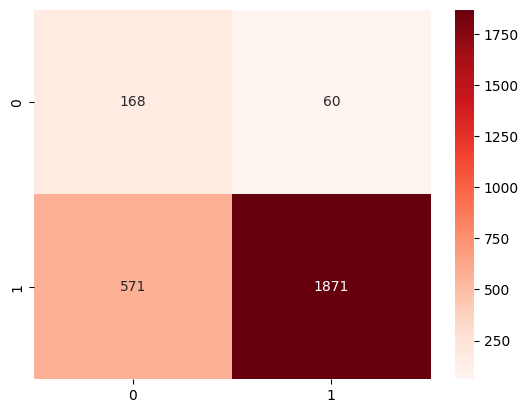

In [36]:
y_pred_yand_14 = metric(yandex, 'USE_M', 'Siuu', 0, 128)

In [37]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifier256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -33.741957063463
Val Epoch: 1, F1: 0.500168596816697, Precision: 0.6071550137245407, Recall: 0.6092222222222222
Val Epoch: 1, F1: 0.4991111013036112, Precision: 0.6071492216747195, Recall: 0.6078623927920714 

Train Epoch: 2, Loss: -34.405927800284495
Val Epoch: 2, F1: 0.4966859256579158, Precision: 0.590126090323787, Recall: 0.6114444444444445
Val Epoch: 2, F1: 0.495566720444915, Precision: 0.589973746425222, Recall: 0.6100284049833667 

Train Epoch: 3, Loss: -34.76925729921129
Val Epoch: 3, F1: 0.4908278111044218, Precision: 0.6167111664911542, Recall: 0.6077222222222223
Val Epoch: 3, F1: 0.48971970452672914, Precision: 0.616751283802099, Recall: 0.6063239767887189 

Train Epoch: 4, Loss: -34.384632259580826
Val Epoch: 4, F1: 0.4960464428213092, Precision: 0.6139273109894464, Recall: 0.6126111111111111
Val Epoch: 4, F1: 0.49492747048602953, Precision: 0.6139101416199638, Recall: 0.6111961741169804 

Train Epoch: 5, Loss: -34.50467876582675
Val Epoch: 5, F1: 0.49

Accuracy:  0.8651685393258427
F1: 0.8821499816374104, Precision: 0.9088591375823561, Recall: 0.8651685393258427
F1: 0.6821664003724592, Precision: 0.6515958808272473, Recall: 0.7553019526703737 

              precision    recall  f1-score   support

          -1       0.34      0.62      0.44       228
           1       0.96      0.89      0.92      2442

    accuracy                           0.87      2670
   macro avg       0.65      0.76      0.68      2670
weighted avg       0.91      0.87      0.88      2670



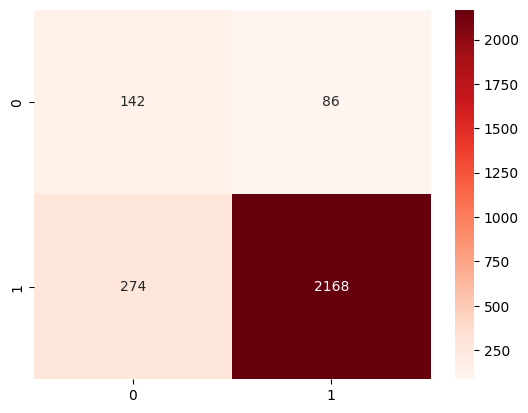

In [38]:
y_pred_yand_15 = metric(yandex, 'USE_M', 'Siuu', 0, 64)

In [39]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifier256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -16.65768831009335
Val Epoch: 1, F1: 0.4989555615320735, Precision: 0.6148996702596476, Recall: 0.6120555555555556
Val Epoch: 1, F1: 0.4966540615857104, Precision: 0.6146663099909603, Recall: 0.6093242801540195 

Train Epoch: 2, Loss: -16.914113858858745
Val Epoch: 2, F1: 0.49149843994985554, Precision: 0.6135367551488761, Recall: 0.6078333333333333
Val Epoch: 2, F1: 0.4892393368298304, Precision: 0.6135013279230013, Recall: 0.6050324580044387 

Train Epoch: 3, Loss: -17.050033139122856
Val Epoch: 3, F1: 0.49398058386248883, Precision: 0.6474359199142062, Recall: 0.6078888888888889
Val Epoch: 3, F1: 0.49162894192341766, Precision: 0.6474148885660141, Recall: 0.6051954395606084 

Train Epoch: 4, Loss: -17.063907320128546
Val Epoch: 4, F1: 0.490163089430799, Precision: 0.596236943127339, Recall: 0.6068333333333333
Val Epoch: 4, F1: 0.487847958663662, Precision: 0.5959292531793123, Recall: 0.6040787203589321 

Train Epoch: 5, Loss: -16.96366630850898
Val Epoch: 5, F1

Accuracy:  0.8745318352059925
F1: 0.8882638014632048, Precision: 0.908951941258863, Recall: 0.8745318352059925
F1: 0.6895541720941323, Precision: 0.6599123504057406, Recall: 0.7504795465321781 

              precision    recall  f1-score   support

          -1       0.36      0.60      0.45       228
           1       0.96      0.90      0.93      2442

    accuracy                           0.87      2670
   macro avg       0.66      0.75      0.69      2670
weighted avg       0.91      0.87      0.89      2670



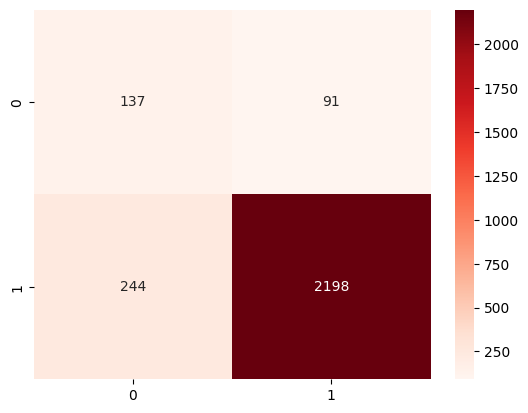

In [40]:
y_pred_yand_16 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

In [41]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifier256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -7.940740593274435
Val Epoch: 1, F1: 0.48328958137891037, Precision: 0.593586500289842, Recall: 0.5972222222222222
Val Epoch: 1, F1: 0.4803844907370016, Precision: 0.5935320341300818, Recall: 0.5935323309618181 

Train Epoch: 2, Loss: -8.197349266290665
Val Epoch: 2, F1: 0.4927460845525273, Precision: 0.564180778864076, Recall: 0.6075
Val Epoch: 2, F1: 0.48966066021212057, Precision: 0.5632991912929249, Recall: 0.6038308468392372 

Train Epoch: 3, Loss: -8.165756735086442
Val Epoch: 3, F1: 0.4908381222455664, Precision: 0.6037474812434055, Recall: 0.6075555555555555
Val Epoch: 3, F1: 0.48779723177839057, Precision: 0.6035481778231079, Recall: 0.6038426655685254 

Train Epoch: 4, Loss: -8.202521017154059
Val Epoch: 4, F1: 0.48818914925066587, Precision: 0.5780380644065366, Recall: 0.6064444444444445
Val Epoch: 4, F1: 0.48518027859323726, Precision: 0.5776466851040448, Recall: 0.6026851070133267 

Train Epoch: 5, Loss: -8.242026706563102
Val Epoch: 5, F1: 0.48916729

Accuracy:  0.7820224719101123
F1: 0.8245403358161848, Precision: 0.9007660116180108, Recall: 0.7820224719101123
F1: 0.6076404494382022, Precision: 0.5978879045750533, Recall: 0.73370619423251 

              precision    recall  f1-score   support

          -1       0.23      0.68      0.35       228
           1       0.96      0.79      0.87      2442

    accuracy                           0.78      2670
   macro avg       0.60      0.73      0.61      2670
weighted avg       0.90      0.78      0.82      2670



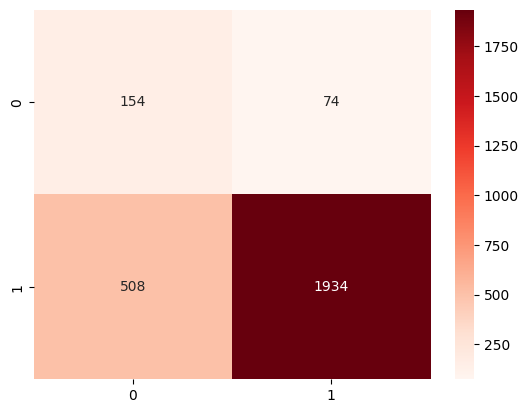

In [42]:
y_pred_yand_17 = metric(yandex, 'USE_M', 'Siuu', 0, 16)

In [43]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifier256(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2684796086213093
Val Epoch: 1, F1: 0.7132069435799101, Precision: 0.7478626073526388, Recall: 0.7098888888888889
Val Epoch: 1, F1: 0.7133141642015831, Precision: 0.7475551421030815, Recall: 0.7103794513646896 

Train Epoch: 2, Loss: 0.24572194829503766
Val Epoch: 2, F1: 0.7210970480213922, Precision: 0.7447694715481092, Recall: 0.718
Val Epoch: 2, F1: 0.7211714617523302, Precision: 0.7444977339250287, Recall: 0.7183968996063781 

Train Epoch: 3, Loss: 0.24131488927092476
Val Epoch: 3, F1: 0.7248007796151087, Precision: 0.7348650947606247, Recall: 0.7198333333333333
Val Epoch: 3, F1: 0.7247516743370795, Precision: 0.7347792439226543, Recall: 0.7198353667866458 

Train Epoch: 4, Loss: 0.237422267745909
Val Epoch: 4, F1: 0.7218816414068997, Precision: 0.7447764433737941, Recall: 0.7150555555555556
Val Epoch: 4, F1: 0.72188101847985, Precision: 0.744608674903004, Recall: 0.7152525890132123 

Train Epoch: 5, Loss: 0.2346561325326906
Val Epoch: 5, F1: 0.72335472327887

Accuracy:  0.8576779026217228
F1: 0.876688031326094, Precision: 0.9067634932563244, Recall: 0.8576779026217228
F1: 0.6723752888431935, Precision: 0.6429880134868882, Recall: 0.7492187163239795 

              precision    recall  f1-score   support

          -1       0.32      0.62      0.43       228
           1       0.96      0.88      0.92      2442

    accuracy                           0.86      2670
   macro avg       0.64      0.75      0.67      2670
weighted avg       0.91      0.86      0.88      2670



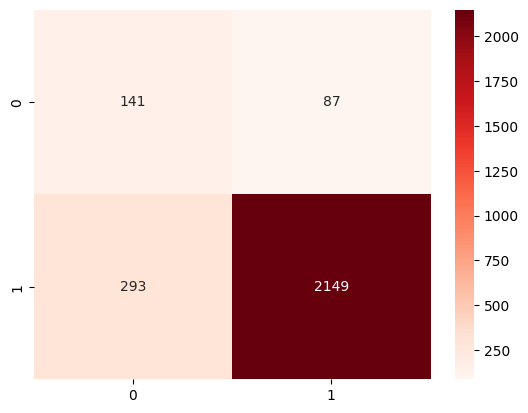

In [44]:
y_pred_yand_18 = metric(yandex, 'USE_M', 'Siuu', 0, 128)

In [45]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifier256(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.26557343198193445
Val Epoch: 1, F1: 0.7218393663077554, Precision: 0.74257766897836, Recall: 0.7148333333333333
Val Epoch: 1, F1: 0.7215301570460112, Precision: 0.7419329324674009, Recall: 0.7148889875378703 

Train Epoch: 2, Loss: 0.24540420790513356
Val Epoch: 2, F1: 0.7153258614680188, Precision: 0.7511723062484287, Recall: 0.7095555555555556
Val Epoch: 2, F1: 0.7151286916518433, Precision: 0.7504091933183852, Recall: 0.709973343219319 

Train Epoch: 3, Loss: 0.24047983958323796
Val Epoch: 3, F1: 0.7250058190629588, Precision: 0.7475746420894207, Recall: 0.7181666666666666
Val Epoch: 3, F1: 0.72472735543555, Precision: 0.7469127403201972, Recall: 0.7183093178503365 

Train Epoch: 4, Loss: 0.23650059744384555
Val Epoch: 4, F1: 0.7301159622395044, Precision: 0.7407166611808398, Recall: 0.7256111111111111
Val Epoch: 4, F1: 0.7298019432635403, Precision: 0.7401522599836046, Recall: 0.7255649614033622 

Train Epoch: 5, Loss: 0.23323958626058366
Val Epoch: 5, F1: 0

Accuracy:  0.8700374531835205
F1: 0.8847785544349541, Precision: 0.906951961720491, Recall: 0.8700374531835205
F1: 0.6820655223189667, Precision: 0.6531360551961042, Recall: 0.7440460795723953 

              precision    recall  f1-score   support

          -1       0.35      0.59      0.44       228
           1       0.96      0.90      0.93      2442

    accuracy                           0.87      2670
   macro avg       0.65      0.74      0.68      2670
weighted avg       0.91      0.87      0.88      2670



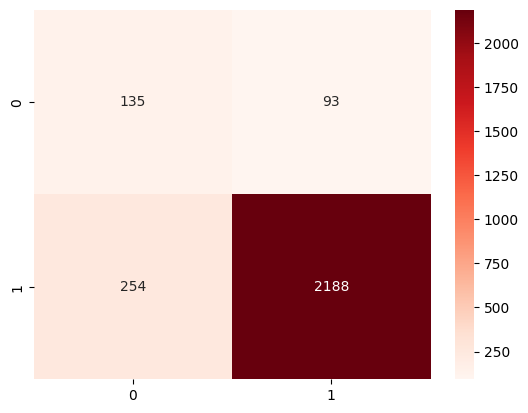

In [46]:
y_pred_yand_19 = metric(yandex, 'USE_M', 'Siuu', 0, 64)

In [47]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifier256(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2637906064656046
Val Epoch: 1, F1: 0.7202135311082064, Precision: 0.7382049871999685, Recall: 0.7146111111111111
Val Epoch: 1, F1: 0.719329073335636, Precision: 0.7370196713458835, Recall: 0.7140636431768143 

Train Epoch: 2, Loss: 0.24676542988419534
Val Epoch: 2, F1: 0.7199233573980889, Precision: 0.7552930100717418, Recall: 0.7151111111111111
Val Epoch: 2, F1: 0.7190547571261531, Precision: 0.7542114378014181, Recall: 0.7146171149278899 

Train Epoch: 3, Loss: 0.24215995882285965
Val Epoch: 3, F1: 0.7175943099269853, Precision: 0.7525162733649358, Recall: 0.7143888888888889
Val Epoch: 3, F1: 0.7166479607364584, Precision: 0.7515230224821027, Recall: 0.7137001766017234 

Train Epoch: 4, Loss: 0.23710512290729416
Val Epoch: 4, F1: 0.73046299870306, Precision: 0.7463931297046051, Recall: 0.7258888888888889
Val Epoch: 4, F1: 0.7295934488272858, Precision: 0.7453321351062944, Recall: 0.7252657997502023 

Train Epoch: 5, Loss: 0.23340994022289913
Val Epoch: 5, F1: 

Accuracy:  0.8674157303370786
F1: 0.8851251660248348, Precision: 0.914638836891591, Recall: 0.8674157303370786
F1: 0.6947917164486592, Precision: 0.6608719487564199, Recall: 0.7803892409155567 

              precision    recall  f1-score   support

          -1       0.35      0.68      0.47       228
           1       0.97      0.89      0.92      2442

    accuracy                           0.87      2670
   macro avg       0.66      0.78      0.69      2670
weighted avg       0.91      0.87      0.89      2670



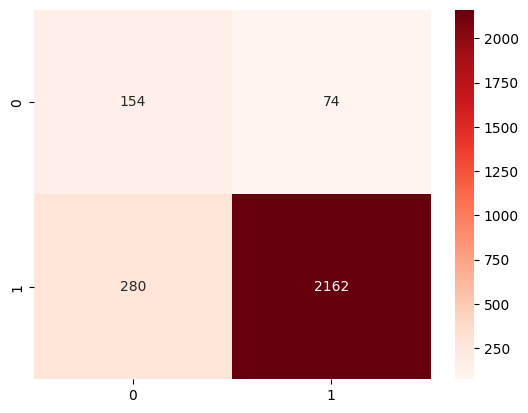

In [48]:
y_pred_yand_20 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

In [49]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifier256(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2616269727531407
Val Epoch: 1, F1: 0.7130254569001343, Precision: 0.7431630264997966, Recall: 0.7071111111111111
Val Epoch: 1, F1: 0.712788886243532, Precision: 0.7429521640008546, Recall: 0.7068669654044696 

Train Epoch: 2, Loss: 0.2456098737311032
Val Epoch: 2, F1: 0.7061243302666514, Precision: 0.7242262308599492, Recall: 0.6999444444444445
Val Epoch: 2, F1: 0.7059796344934987, Precision: 0.7238448610375343, Recall: 0.6999979746231587 

Train Epoch: 3, Loss: 0.24081245424060357
Val Epoch: 3, F1: 0.7185750441700719, Precision: 0.7410631461849265, Recall: 0.7118888888888889
Val Epoch: 3, F1: 0.7183797973505861, Precision: 0.7408111749414736, Recall: 0.7117392823429576 

Train Epoch: 4, Loss: 0.23613674533656903
Val Epoch: 4, F1: 0.7176868512172505, Precision: 0.7488223420950223, Recall: 0.7114444444444444
Val Epoch: 4, F1: 0.7174540697765335, Precision: 0.7486058296992137, Recall: 0.7112104285359168 

Train Epoch: 5, Loss: 0.2325724190502531
Val Epoch: 5, F1: 

Accuracy:  0.8700374531835205
F1: 0.8856443097197585, Precision: 0.9099995278591917, Recall: 0.8700374531835205
F1: 0.6881952790270107, Precision: 0.657210861196518, Recall: 0.7579637053321264 

              precision    recall  f1-score   support

          -1       0.35      0.62      0.45       228
           1       0.96      0.89      0.93      2442

    accuracy                           0.87      2670
   macro avg       0.66      0.76      0.69      2670
weighted avg       0.91      0.87      0.89      2670



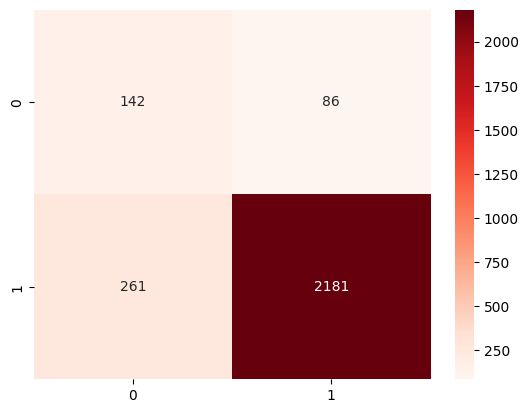

In [50]:
y_pred_yand_21 = metric(yandex, 'USE_M', 'Siuu', 0, 16)

# **Обучение на rubert-tiny2 256 нейронов**

In [51]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifierTiny256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -63.69421629541509
Val Epoch: 1, F1: 0.5159482483729096, Precision: 0.6150513207259165, Recall: 0.6123888888888889
Val Epoch: 1, F1: 0.514414222468815, Precision: 0.6151341407098723, Recall: 0.6102268908634119 

Train Epoch: 2, Loss: -66.99232290989552
Val Epoch: 2, F1: 0.5051381744500377, Precision: 0.5956547828851083, Recall: 0.6116111111111111
Val Epoch: 2, F1: 0.503501414509019, Precision: 0.595596853797613, Recall: 0.6094024510792965 

Train Epoch: 3, Loss: -67.3948639129449
Val Epoch: 3, F1: 0.5026869188909813, Precision: 0.6140728545710773, Recall: 0.6101666666666666
Val Epoch: 3, F1: 0.5010487174287418, Precision: 0.6141709248034245, Recall: 0.6079410258134347 

Train Epoch: 4, Loss: -67.48248401458903
Val Epoch: 4, F1: 0.4967206277679996, Precision: 0.5953537313395338, Recall: 0.608
Val Epoch: 4, F1: 0.4950419071078387, Precision: 0.5953229643570787, Recall: 0.6057790386534782 

Train Epoch: 5, Loss: -68.0340345409793
Val Epoch: 5, F1: 0.49614601821242266

Accuracy:  0.8704119850187266
F1: 0.8839941212724599, Precision: 0.9035616958629895, Recall: 0.8704119850187266
F1: 0.675168776371308, Precision: 0.6487232937477189, Recall: 0.7283449717660244 

              precision    recall  f1-score   support

          -1       0.34      0.56      0.42       228
           1       0.96      0.90      0.93      2442

    accuracy                           0.87      2670
   macro avg       0.65      0.73      0.68      2670
weighted avg       0.90      0.87      0.88      2670



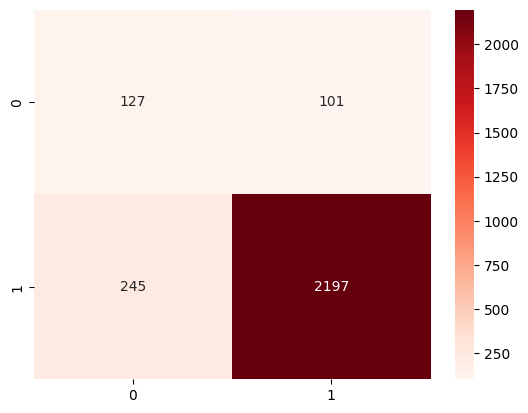

In [52]:
y_pred_yand_22 = metric(yandex, 'tiny2', 'Siuu', 0, 128)

In [53]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifierTiny256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -31.772822749243844
Val Epoch: 1, F1: 0.4868092317013498, Precision: 0.579755401758094, Recall: 0.5892222222222222
Val Epoch: 1, F1: 0.4900026882143294, Precision: 0.5798650077176867, Recall: 0.5936910533448437 

Train Epoch: 2, Loss: -33.03340597746107
Val Epoch: 2, F1: 0.48547813221101227, Precision: 0.5811635383771105, Recall: 0.5954444444444444
Val Epoch: 2, F1: 0.4889049090722393, Precision: 0.5815167289365122, Recall: 0.5998425961789339 

Train Epoch: 3, Loss: -33.25543878195021
Val Epoch: 3, F1: 0.489447834019978, Precision: 0.572977353538017, Recall: 0.6008333333333333
Val Epoch: 3, F1: 0.49315497820121323, Precision: 0.574075355774525, Recall: 0.6050179182991527 

Train Epoch: 4, Loss: -33.23305091349284
Val Epoch: 4, F1: 0.4809416601052912, Precision: 0.5749107304777608, Recall: 0.5945555555555555
Val Epoch: 4, F1: 0.48454209008005256, Precision: 0.5755138802629939, Recall: 0.5989660759240353 

Train Epoch: 5, Loss: -33.053259788725114
Val Epoch: 5, F1: 

Accuracy:  0.8131086142322097
F1: 0.8472672342899676, Precision: 0.9092438457484144, Recall: 0.8131086142322097
F1: 0.642315513943421, Precision: 0.6208381511998002, Recall: 0.7685945514892883 

              precision    recall  f1-score   support

          -1       0.27      0.71      0.40       228
           1       0.97      0.82      0.89      2442

    accuracy                           0.81      2670
   macro avg       0.62      0.77      0.64      2670
weighted avg       0.91      0.81      0.85      2670



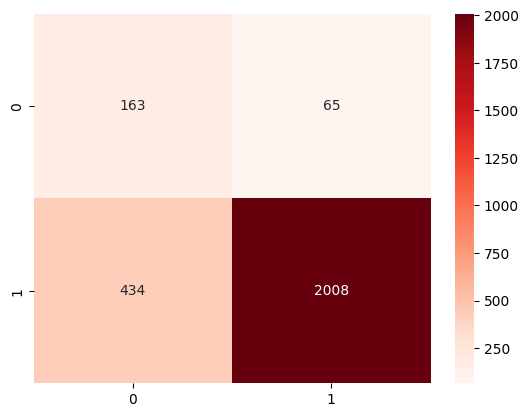

In [54]:
y_pred_yand_23 = metric(yandex, 'tiny2', 'Siuu', 0, 64)

In [55]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifierTiny256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -15.693977903260125
Val Epoch: 1, F1: 0.4838996041750773, Precision: 0.5741099300358458, Recall: 0.5933333333333334
Val Epoch: 1, F1: 0.4856813523468684, Precision: 0.5744923178601726, Recall: 0.5955724251850486 

Train Epoch: 2, Loss: -16.069512288305493
Val Epoch: 2, F1: 0.4795827279579195, Precision: 0.5586325383103268, Recall: 0.5905
Val Epoch: 2, F1: 0.48130667825565987, Precision: 0.5589499345083677, Recall: 0.5928664274554069 

Train Epoch: 3, Loss: -16.170799838172066
Val Epoch: 3, F1: 0.480065243795467, Precision: 0.583699005371036, Recall: 0.5954444444444444
Val Epoch: 3, F1: 0.48181553367621605, Precision: 0.5839205246039456, Recall: 0.5977102455447026 

Train Epoch: 4, Loss: -16.246853119744195
Val Epoch: 4, F1: 0.4842314687519078, Precision: 0.56418928786439, Recall: 0.5985
Val Epoch: 4, F1: 0.48625090635253937, Precision: 0.5651657169583236, Recall: 0.6003600795032921 

Train Epoch: 5, Loss: -16.09365610493554
Val Epoch: 5, F1: 0.4854162408617771, Pr

Accuracy:  0.7191011235955056
F1: 0.7801912191926911, Precision: 0.9085651111363101, Recall: 0.7191011235955055
F1: 0.5746388306635591, Precision: 0.5898164269301238, Recall: 0.7549786628733997 

              precision    recall  f1-score   support

          -1       0.21      0.80      0.33       228
           1       0.97      0.71      0.82      2442

    accuracy                           0.72      2670
   macro avg       0.59      0.75      0.57      2670
weighted avg       0.91      0.72      0.78      2670



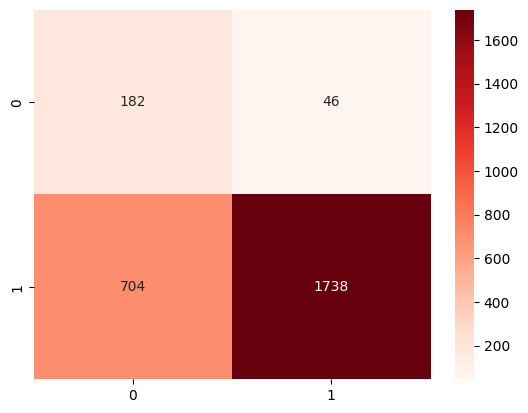

In [56]:
y_pred_yand_24 = metric(yandex, 'tiny2', 'Siuu', 0, 32)

In [57]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifierTiny256(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -7.647186862733629
Val Epoch: 1, F1: 0.4796788910340387, Precision: 0.5956008718663905, Recall: 0.5895
Val Epoch: 1, F1: 0.48311558665598514, Precision: 0.5965715997744981, Recall: 0.5929457246390681 

Train Epoch: 2, Loss: -7.8164759125709535
Val Epoch: 2, F1: 0.4770990313145772, Precision: 0.5615258422076822, Recall: 0.5896666666666667
Val Epoch: 2, F1: 0.4805678567723202, Precision: 0.5629594281862151, Recall: 0.5930749937332972 

Train Epoch: 3, Loss: -7.862582051118215
Val Epoch: 3, F1: 0.47747475667210304, Precision: 0.5420521000122959, Recall: 0.5921666666666666
Val Epoch: 3, F1: 0.4808724392414077, Precision: 0.5433811326090838, Recall: 0.5958717963737357 

Train Epoch: 4, Loss: -7.958824966748556
Val Epoch: 4, F1: 0.4765318138354181, Precision: 0.5760919378423266, Recall: 0.5921666666666666
Val Epoch: 4, F1: 0.4797894639028189, Precision: 0.5765939809421877, Recall: 0.5961642057601395 

Train Epoch: 5, Loss: -7.924888140334024
Val Epoch: 5, F1: 0.46565311

Accuracy:  0.5146067415730337
F1: 0.6084292818573643, Precision: 0.9127301880509194, Recall: 0.5146067415730337
F1: 0.4435696753577549, Precision: 0.5629503029310627, Recall: 0.698855554118712 

              precision    recall  f1-score   support

          -1       0.14      0.92      0.24       228
           1       0.98      0.48      0.64      2442

    accuracy                           0.51      2670
   macro avg       0.56      0.70      0.44      2670
weighted avg       0.91      0.51      0.61      2670



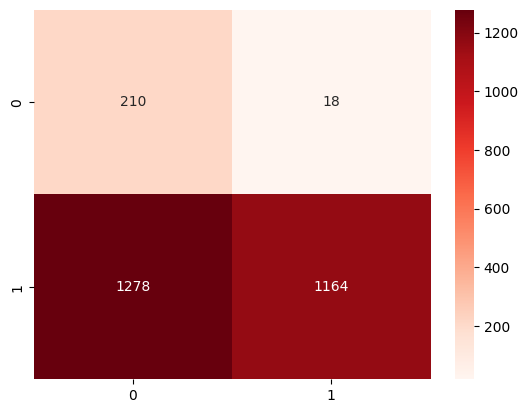

In [58]:
y_pred_yand_25 = metric(yandex, 'tiny2', 'Siuu', 0, 16)

In [59]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifierTiny256(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.29560583107319016
Val Epoch: 1, F1: 0.6857304314472369, Precision: 0.7437361322911016, Recall: 0.6783888888888889
Val Epoch: 1, F1: 0.6859105733482517, Precision: 0.7440181471644665, Recall: 0.6784594515065491 

Train Epoch: 2, Loss: 0.267743506318299
Val Epoch: 2, F1: 0.6937254427597642, Precision: 0.7293894441754487, Recall: 0.6898888888888889
Val Epoch: 2, F1: 0.6939771768213379, Precision: 0.7295650848566823, Recall: 0.6901528201935342 

Train Epoch: 3, Loss: 0.26299455174332614
Val Epoch: 3, F1: 0.6979882721486848, Precision: 0.7440201552037087, Recall: 0.6914444444444444
Val Epoch: 3, F1: 0.6981984370995752, Precision: 0.7442727273844261, Recall: 0.691583408692312 

Train Epoch: 4, Loss: 0.2591077339691548
Val Epoch: 4, F1: 0.7011293453485875, Precision: 0.7490826893068478, Recall: 0.6941111111111111
Val Epoch: 4, F1: 0.7013281176410299, Precision: 0.749354440760191, Recall: 0.6942205793092331 

Train Epoch: 5, Loss: 0.2561521825527848
Val Epoch: 5, F1: 0.

Accuracy:  0.7419475655430712
F1: 0.7968156975962177, Precision: 0.9064343223903368, Recall: 0.7419475655430712
F1: 0.587731283885948, Precision: 0.5930318441976979, Recall: 0.7515625673520411 

              precision    recall  f1-score   support

          -1       0.22      0.76      0.34       228
           1       0.97      0.74      0.84      2442

    accuracy                           0.74      2670
   macro avg       0.59      0.75      0.59      2670
weighted avg       0.91      0.74      0.80      2670



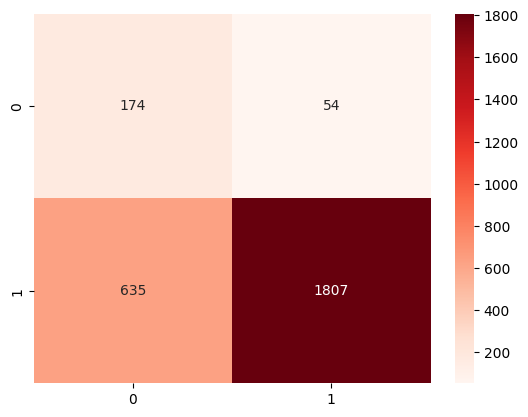

In [60]:
y_pred_yand_26 = metric(yandex, 'tiny2', 'Siuu', 0, 128)

In [61]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifierTiny256(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2888722566101286
Val Epoch: 1, F1: 0.6968038572909135, Precision: 0.7324403027949288, Recall: 0.6903888888888889
Val Epoch: 1, F1: 0.6978783007424111, Precision: 0.7340795122766933, Recall: 0.69078485984835 

Train Epoch: 2, Loss: 0.26844021639559
Val Epoch: 2, F1: 0.7056290608779517, Precision: 0.7308235923002421, Recall: 0.6993333333333334
Val Epoch: 2, F1: 0.7066468435506984, Precision: 0.7323627860022404, Recall: 0.6997703073071286 

Train Epoch: 3, Loss: 0.26310690116882324
Val Epoch: 3, F1: 0.7106157147625695, Precision: 0.7311612289903977, Recall: 0.7045
Val Epoch: 3, F1: 0.7116258236375796, Precision: 0.7327368598833388, Recall: 0.7049279216627041 

Train Epoch: 4, Loss: 0.2584190766943826
Val Epoch: 4, F1: 0.7056026095025925, Precision: 0.7419564820564079, Recall: 0.6992777777777778
Val Epoch: 4, F1: 0.7066551847913413, Precision: 0.7435641911864738, Recall: 0.6996514411657744 

Train Epoch: 5, Loss: 0.25503161008490455
Val Epoch: 5, F1: 0.7153013664660

Accuracy:  0.8569288389513109
F1: 0.875803281964017, Precision: 0.9052644275635522, Recall: 0.8569288389513109
F1: 0.6689319115178223, Precision: 0.6403758305647841, Recall: 0.7428445191603086 

              precision    recall  f1-score   support

          -1       0.32      0.61      0.42       228
           1       0.96      0.88      0.92      2442

    accuracy                           0.86      2670
   macro avg       0.64      0.74      0.67      2670
weighted avg       0.91      0.86      0.88      2670



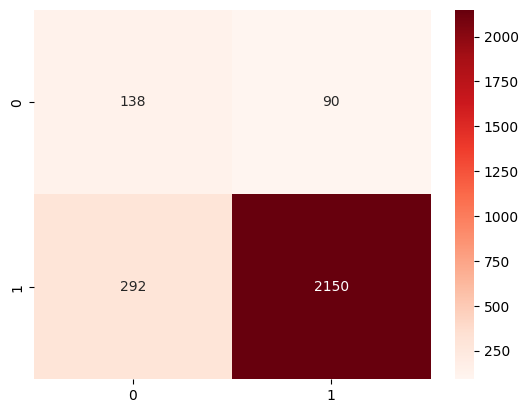

In [62]:
y_pred_yand_27 = metric(yandex, 'tiny2', 'Siuu', 0, 64)

In [63]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifierTiny256(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.28716732048657206
Val Epoch: 1, F1: 0.7043765897564063, Precision: 0.7294614116646065, Recall: 0.6978333333333333
Val Epoch: 1, F1: 0.704436607484411, Precision: 0.7290881901969289, Recall: 0.6983507677858011 

Train Epoch: 2, Loss: 0.2680137966540125
Val Epoch: 2, F1: 0.697224218873276, Precision: 0.7347026964978849, Recall: 0.6881111111111111
Val Epoch: 2, F1: 0.6971287956111837, Precision: 0.7345058182964923, Recall: 0.6882717907976447 

Train Epoch: 3, Loss: 0.2629966762761275
Val Epoch: 3, F1: 0.707388588906115, Precision: 0.7137971795728273, Recall: 0.7058333333333333
Val Epoch: 3, F1: 0.70737553171121, Precision: 0.7134109797809377, Recall: 0.7061653344011057 

Train Epoch: 4, Loss: 0.25809533535440765
Val Epoch: 4, F1: 0.7068401191247498, Precision: 0.7496830707468111, Recall: 0.701
Val Epoch: 4, F1: 0.7070326796767223, Precision: 0.7491261868537055, Recall: 0.7019073125923373 

Train Epoch: 5, Loss: 0.2543589746952057
Val Epoch: 5, F1: 0.713090133433843

Accuracy:  0.8569288389513109
F1: 0.8753204172986161, Precision: 0.9034779043525373, Recall: 0.8569288389513109
F1: 0.6654288994587502, Precision: 0.6378602992022399, Recall: 0.7348915901547481 

              precision    recall  f1-score   support

          -1       0.32      0.59      0.41       228
           1       0.96      0.88      0.92      2442

    accuracy                           0.86      2670
   macro avg       0.64      0.73      0.67      2670
weighted avg       0.90      0.86      0.88      2670



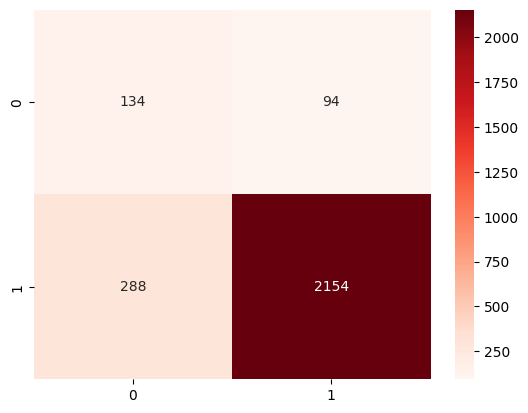

In [64]:
y_pred_yand_28 = metric(yandex, 'tiny2', 'Siuu', 0, 32)

In [65]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifierTiny256(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.28493268283166817
Val Epoch: 1, F1: 0.7032487470592684, Precision: 0.7198089891654533, Recall: 0.6967222222222222
Val Epoch: 1, F1: 0.7033171348849887, Precision: 0.7197988531074314, Recall: 0.696946636505837 

Train Epoch: 2, Loss: 0.2668603158469001
Val Epoch: 2, F1: 0.7005771057135464, Precision: 0.7320517519469804, Recall: 0.6932777777777778
Val Epoch: 2, F1: 0.70083573011784, Precision: 0.7318206729171682, Recall: 0.6940885214658978 

Train Epoch: 3, Loss: 0.26132197802265483
Val Epoch: 3, F1: 0.7068814411058523, Precision: 0.7262872588785328, Recall: 0.7031666666666667
Val Epoch: 3, F1: 0.7072392591385146, Precision: 0.7258509942873337, Recall: 0.7042315164052274 

Train Epoch: 4, Loss: 0.2563726532186071
Val Epoch: 4, F1: 0.7118604478213935, Precision: 0.7393919322749379, Recall: 0.7051666666666667
Val Epoch: 4, F1: 0.7121260931781049, Precision: 0.7391643278315341, Recall: 0.7059711122381641 

Train Epoch: 5, Loss: 0.2525583582164513
Val Epoch: 5, F1: 0.

Accuracy:  0.8250936329588014
F1: 0.8556045182787028, Precision: 0.9100577556973006, Recall: 0.8250936329588014
F1: 0.6527483618274679, Precision: 0.6276094557828304, Recall: 0.7711700935385146 

              precision    recall  f1-score   support

          -1       0.29      0.71      0.41       228
           1       0.97      0.84      0.90      2442

    accuracy                           0.83      2670
   macro avg       0.63      0.77      0.65      2670
weighted avg       0.91      0.83      0.86      2670



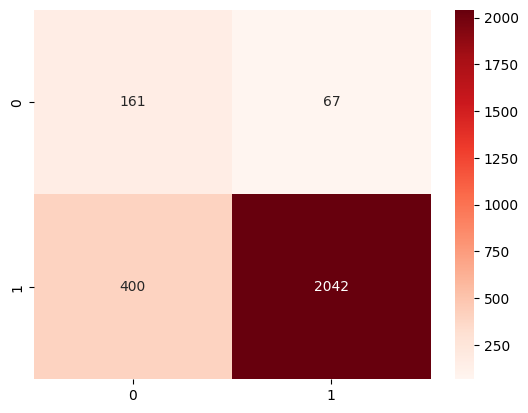

In [66]:
y_pred_yand_29 = metric(yandex, 'tiny2', 'Siuu', 0, 16)

# **Обучение USE-M на 64 нейрона**

In [67]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifier64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -67.16117901996863
Val Epoch: 1, F1: 0.5089873550862073, Precision: 0.5914586603623807, Recall: 0.6136666666666667
Val Epoch: 1, F1: 0.5076754924507351, Precision: 0.5913469176314482, Recall: 0.6119496479778308 

Train Epoch: 2, Loss: -70.03955115052354
Val Epoch: 2, F1: 0.5073261974471189, Precision: 0.616785459523853, Recall: 0.6161666666666666
Val Epoch: 2, F1: 0.505979126803454, Precision: 0.6168078075754683, Recall: 0.6143835839773665 

Train Epoch: 3, Loss: -70.39101227646823
Val Epoch: 3, F1: 0.5060466260619145, Precision: 0.6256325044729494, Recall: 0.6165
Val Epoch: 3, F1: 0.5046848617695148, Precision: 0.6257047198316451, Recall: 0.6146999465771186 

Train Epoch: 4, Loss: -70.64118360160299
Val Epoch: 4, F1: 0.5018743691429403, Precision: 0.5984331035911443, Recall: 0.6144444444444445
Val Epoch: 4, F1: 0.5005000714260072, Precision: 0.5983592630040523, Recall: 0.6126522476684381 

Train Epoch: 5, Loss: -70.73926741276499
Val Epoch: 5, F1: 0.4956266302045

Accuracy:  0.8685393258426967
F1: 0.885268336977918, Precision: 0.9122646112452757, Recall: 0.8685393258426967
F1: 0.6913519461225259, Precision: 0.6588410984669768, Recall: 0.7690740980214665 

              precision    recall  f1-score   support

          -1       0.35      0.65      0.46       228
           1       0.96      0.89      0.93      2442

    accuracy                           0.87      2670
   macro avg       0.66      0.77      0.69      2670
weighted avg       0.91      0.87      0.89      2670



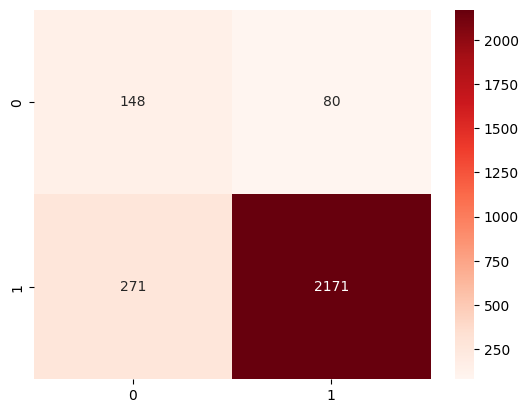

In [68]:
y_pred_yand_30 = metric(yandex, 'USE_M', 'Siuu', 0, 128)

In [69]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifier64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -33.971375566906396
Val Epoch: 1, F1: 0.5025405988208319, Precision: 0.5853693208072602, Recall: 0.6108888888888889
Val Epoch: 1, F1: 0.5000219829772444, Precision: 0.5844711145454684, Recall: 0.6082169121526679 

Train Epoch: 2, Loss: -35.02567414347331
Val Epoch: 2, F1: 0.5020170514415915, Precision: 0.6014896805152712, Recall: 0.6122777777777778
Val Epoch: 2, F1: 0.49945042562445935, Precision: 0.6006656890516897, Recall: 0.6096175137785779 

Train Epoch: 3, Loss: -35.29192159377204
Val Epoch: 3, F1: 0.4970555665021182, Precision: 0.6157745243205692, Recall: 0.6113888888888889
Val Epoch: 3, F1: 0.4945846919186088, Precision: 0.6154157729740973, Recall: 0.6085878466081615 

Train Epoch: 4, Loss: -35.26382934909397
Val Epoch: 4, F1: 0.4986477369997819, Precision: 0.5958621223733367, Recall: 0.6111111111111112
Val Epoch: 4, F1: 0.49601172119801973, Precision: 0.5948996946956079, Recall: 0.6084579786877283 

Train Epoch: 5, Loss: -35.243286987304685
Val Epoch: 5, F

Accuracy:  0.8745318352059925
F1: 0.8891271658027331, Precision: 0.9119673533691454, Recall: 0.8745318352059925
F1: 0.6956297889094158, Precision: 0.6638169425511198, Recall: 0.7643971722919092 

              precision    recall  f1-score   support

          -1       0.36      0.63      0.46       228
           1       0.96      0.90      0.93      2442

    accuracy                           0.87      2670
   macro avg       0.66      0.76      0.70      2670
weighted avg       0.91      0.87      0.89      2670



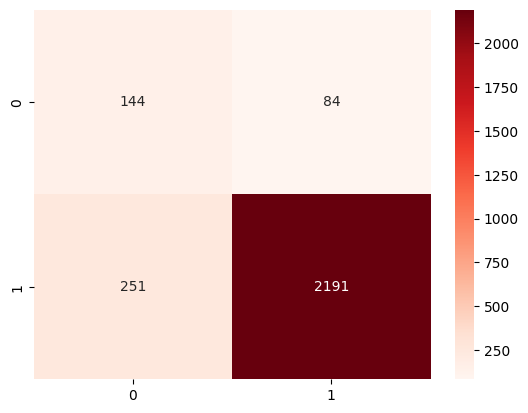

In [70]:
y_pred_yand_31 = metric(yandex, 'USE_M', 'Siuu', 0, 64)

In [71]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifier64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -16.736114511913723
Val Epoch: 1, F1: 0.4938275079726443, Precision: 0.6094386902427387, Recall: 0.6022777777777778
Val Epoch: 1, F1: 0.4980793303295547, Precision: 0.6095616376985947, Recall: 0.6080136007750259 

Train Epoch: 2, Loss: -17.0996490117179
Val Epoch: 2, F1: 0.48204197211467037, Precision: 0.601861095861387, Recall: 0.6003888888888889
Val Epoch: 2, F1: 0.48640169358281476, Precision: 0.6017745826223403, Recall: 0.6059230774390844 

Train Epoch: 3, Loss: -17.17319568655226
Val Epoch: 3, F1: 0.48274647234304696, Precision: 0.5523124215673304, Recall: 0.6031111111111112
Val Epoch: 3, F1: 0.4871674659372592, Precision: 0.5531864207534566, Recall: 0.6087900805449945 

Train Epoch: 4, Loss: -17.15968229389191
Val Epoch: 4, F1: 0.4815919530998575, Precision: 0.559519029813408, Recall: 0.6022777777777778
Val Epoch: 4, F1: 0.4860160840873375, Precision: 0.5602381952252699, Recall: 0.6079365580659993 

Train Epoch: 5, Loss: -17.2471445089976
Val Epoch: 5, F1: 0

Accuracy:  0.8269662921348314
F1: 0.8562097267687047, Precision: 0.906597035395896, Recall: 0.8269662921348314
F1: 0.648693815616798, Precision: 0.6240610328638498, Recall: 0.7562879865511445 

              precision    recall  f1-score   support

          -1       0.28      0.67      0.40       228
           1       0.96      0.84      0.90      2442

    accuracy                           0.83      2670
   macro avg       0.62      0.76      0.65      2670
weighted avg       0.91      0.83      0.86      2670



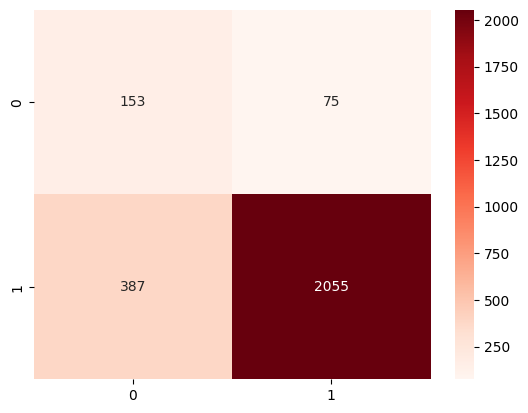

In [72]:
y_pred_yand_32 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

In [73]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifier64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: -7.952482021172841
Val Epoch: 1, F1: 0.49398069368037534, Precision: 0.5831600182557264, Recall: 0.6071111111111112
Val Epoch: 1, F1: 0.49355064946090543, Precision: 0.5838724766336463, Recall: 0.6056568839318154 

Train Epoch: 2, Loss: -8.104258051978217
Val Epoch: 2, F1: 0.49349597453889954, Precision: 0.6204995690504033, Recall: 0.6103888888888889
Val Epoch: 2, F1: 0.49288310994974305, Precision: 0.6209660632762325, Recall: 0.6092861480314733 

Train Epoch: 3, Loss: -8.062043149338828
Val Epoch: 3, F1: 0.47801515982101533, Precision: 0.5769882399993991, Recall: 0.5946666666666667
Val Epoch: 3, F1: 0.4771498973639809, Precision: 0.576772344879268, Recall: 0.5940277548930353 

Train Epoch: 4, Loss: -8.140961399316788
Val Epoch: 4, F1: 0.5000387753984212, Precision: 0.6121386313739144, Recall: 0.6115555555555555
Val Epoch: 4, F1: 0.4994491256626717, Precision: 0.6125467436514566, Recall: 0.610507813644126 

Train Epoch: 5, Loss: -8.221452763742871
Val Epoch: 5, F1

Accuracy:  0.850936329588015
F1: 0.8725703824772176, Precision: 0.9080776407409892, Recall: 0.850936329588015
F1: 0.6696136320674937, Precision: 0.6400461515615719, Recall: 0.7574626061468166 

              precision    recall  f1-score   support

          -1       0.32      0.64      0.42       228
           1       0.96      0.87      0.91      2442

    accuracy                           0.85      2670
   macro avg       0.64      0.76      0.67      2670
weighted avg       0.91      0.85      0.87      2670



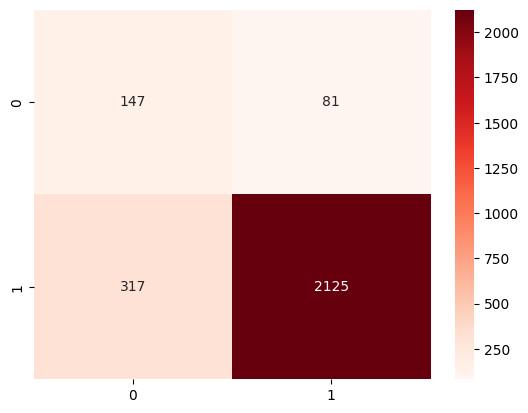

In [74]:
y_pred_yand_33 = metric(yandex, 'USE_M', 'Siuu', 0, 16)

In [75]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifier64(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.27044674034228755
Val Epoch: 1, F1: 0.7197749312090763, Precision: 0.7399295675860146, Recall: 0.7127777777777777
Val Epoch: 1, F1: 0.7193803635255196, Precision: 0.7391367658415139, Recall: 0.7128086773883361 

Train Epoch: 2, Loss: 0.2449664397572116
Val Epoch: 2, F1: 0.7154678907625461, Precision: 0.7492282331441323, Recall: 0.7113888888888888
Val Epoch: 2, F1: 0.7151865480456484, Precision: 0.7483457291253036, Recall: 0.7117557267702606 

Train Epoch: 3, Loss: 0.2413402436099298
Val Epoch: 3, F1: 0.7235781974652085, Precision: 0.7458808997037799, Recall: 0.7173888888888889
Val Epoch: 3, F1: 0.723222331637368, Precision: 0.7450646200832688, Recall: 0.7175360103066116 

Train Epoch: 4, Loss: 0.23801715979038293
Val Epoch: 4, F1: 0.7241950197966645, Precision: 0.7426513424197555, Recall: 0.7204444444444444
Val Epoch: 4, F1: 0.7238479846328415, Precision: 0.7418823017750915, Recall: 0.7205478420401913 

Train Epoch: 5, Loss: 0.23370079970116303
Val Epoch: 5, F1:

Accuracy:  0.8550561797752809
F1: 0.8749402168206121, Precision: 0.906659502674419, Recall: 0.8550561797752809
F1: 0.6701808772003183, Precision: 0.6409623936076938, Recall: 0.7497736971421183 

              precision    recall  f1-score   support

          -1       0.32      0.62      0.42       228
           1       0.96      0.88      0.92      2442

    accuracy                           0.86      2670
   macro avg       0.64      0.75      0.67      2670
weighted avg       0.91      0.86      0.87      2670



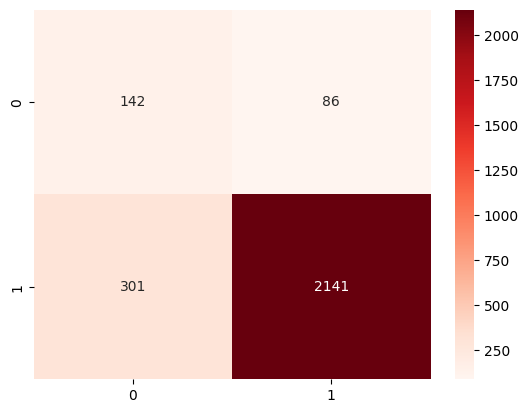

In [76]:
y_pred_yand_34 = metric(yandex, 'USE_M', 'Siuu', 0, 128)

In [77]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifier64(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.26506518725554146
Val Epoch: 1, F1: 0.7234910230199989, Precision: 0.7333875283477286, Recall: 0.7196666666666667
Val Epoch: 1, F1: 0.7241226076811139, Precision: 0.7345791074883715, Recall: 0.7197067947519225 

Train Epoch: 2, Loss: 0.24521298038959502
Val Epoch: 2, F1: 0.7236574911233903, Precision: 0.7410066675777334, Recall: 0.7195555555555555
Val Epoch: 2, F1: 0.7241612287113156, Precision: 0.742343368750429, Recall: 0.7191781809583114 

Train Epoch: 3, Loss: 0.2398504619863298
Val Epoch: 3, F1: 0.7267599179711736, Precision: 0.7395881780903061, Recall: 0.7214444444444444
Val Epoch: 3, F1: 0.7274196609755181, Precision: 0.7407698351409198, Recall: 0.7215479999336994 

Train Epoch: 4, Loss: 0.23501561796002918
Val Epoch: 4, F1: 0.729472112571072, Precision: 0.745949491213465, Recall: 0.7238888888888889
Val Epoch: 4, F1: 0.7300603367721971, Precision: 0.7472364462142395, Recall: 0.7237203660845669 

Train Epoch: 5, Loss: 0.2303096590174569
Val Epoch: 5, F1: 0

Accuracy:  0.8838951310861424
F1: 0.8941182013049725, Precision: 0.9085646807470045, Recall: 0.8838951310861424
F1: 0.6955754165287432, Precision: 0.669010369566528, Recall: 0.7416806758912022 

              precision    recall  f1-score   support

          -1       0.38      0.57      0.46       228
           1       0.96      0.91      0.94      2442

    accuracy                           0.88      2670
   macro avg       0.67      0.74      0.70      2670
weighted avg       0.91      0.88      0.89      2670



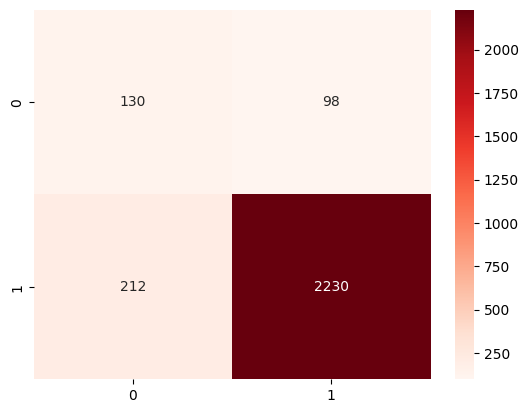

In [78]:
y_pred_yand_35 = metric(yandex, 'USE_M', 'Siuu', 0, 64)

In [79]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifier64(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2632733250161012
Val Epoch: 1, F1: 0.7164238443484519, Precision: 0.7456367338716128, Recall: 0.7093888888888888
Val Epoch: 1, F1: 0.7167527356733738, Precision: 0.7465034791596027, Recall: 0.70913303022217 

Train Epoch: 2, Loss: 0.24436416344013479
Val Epoch: 2, F1: 0.7269856062921018, Precision: 0.7475479502621375, Recall: 0.7226111111111111
Val Epoch: 2, F1: 0.727314681111821, Precision: 0.7483288719973235, Recall: 0.7224511262999179 

Train Epoch: 3, Loss: 0.23812590950065188
Val Epoch: 3, F1: 0.7165701566944351, Precision: 0.7639567239144759, Recall: 0.7113888888888888
Val Epoch: 3, F1: 0.7168108427036058, Precision: 0.7649310916666137, Recall: 0.7108260788028787 

Train Epoch: 4, Loss: 0.2318123912745052
Val Epoch: 4, F1: 0.7322433409611262, Precision: 0.7531885596506775, Recall: 0.7264444444444444
Val Epoch: 4, F1: 0.7325868754303646, Precision: 0.7539830994216947, Recall: 0.7262988369947277 

Train Epoch: 5, Loss: 0.22731158945626684
Val Epoch: 5, F1: 0

Accuracy:  0.8898876404494382
F1: 0.8949308203940465, Precision: 0.9009348072828868, Recall: 0.8898876404494382
F1: 0.6802077358293789, Precision: 0.6657576210400478, Recall: 0.6992273373852321 

              precision    recall  f1-score   support

          -1       0.38      0.47      0.42       228
           1       0.95      0.93      0.94      2442

    accuracy                           0.89      2670
   macro avg       0.67      0.70      0.68      2670
weighted avg       0.90      0.89      0.89      2670



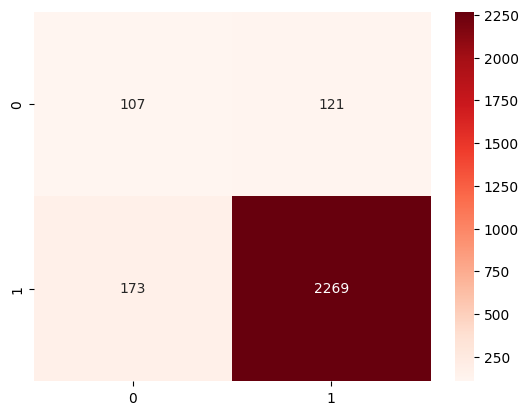

In [80]:
y_pred_yand_36 = metric(yandex, 'USE_M', 'Siuu', 0, 32)

In [81]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifier64(), nn.MSELoss(), False, 0.5, df=data_ru, embed_name='USE_M', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.26109866125302184
Val Epoch: 1, F1: 0.7151468733959422, Precision: 0.7456684980458979, Recall: 0.7112777777777778
Val Epoch: 1, F1: 0.7155809702361182, Precision: 0.74568028590273, Recall: 0.7120323710392952 

Train Epoch: 2, Loss: 0.24496274223758116
Val Epoch: 2, F1: 0.7274492994843038, Precision: 0.7432460134398914, Recall: 0.7233333333333334
Val Epoch: 2, F1: 0.7277744378131504, Precision: 0.743338595654107, Recall: 0.7238594197385412 

Train Epoch: 3, Loss: 0.23827247053529654
Val Epoch: 3, F1: 0.7271995147950434, Precision: 0.7410408200739173, Recall: 0.7215
Val Epoch: 3, F1: 0.7273967041010917, Precision: 0.7414367686717637, Recall: 0.7215484921563079 

Train Epoch: 4, Loss: 0.23383835350390939
Val Epoch: 4, F1: 0.7177994410687344, Precision: 0.7418121364354376, Recall: 0.7105555555555556
Val Epoch: 4, F1: 0.7179257030268942, Precision: 0.7422798199304768, Recall: 0.7104502314600775 

Train Epoch: 5, Loss: 0.22926676971051427
Val Epoch: 5, F1: 0.728341847

Accuracy:  0.8573033707865169
F1: 0.8769912369280143, Precision: 0.9089165509405377, Recall: 0.8573033707865169
F1: 0.6761205657884977, Precision: 0.6456179775280899, Recall: 0.75895512737618 

              precision    recall  f1-score   support

          -1       0.33      0.64      0.43       228
           1       0.96      0.88      0.92      2442

    accuracy                           0.86      2670
   macro avg       0.65      0.76      0.68      2670
weighted avg       0.91      0.86      0.88      2670



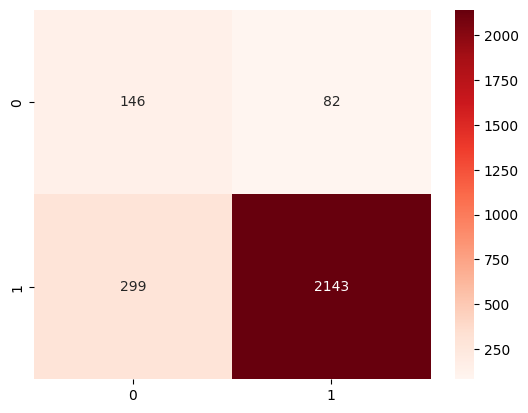

In [82]:
y_pred_yand_37 = metric(yandex, 'USE_M', 'Siuu', 0, 16)

# **Обучение на rubert-tiny2 64 нейрона**

In [83]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifierTiny64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -64.58977143929653
Val Epoch: 1, F1: 0.507285427662672, Precision: 0.5857887495554782, Recall: 0.6043888888888889
Val Epoch: 1, F1: 0.5084995461570387, Precision: 0.5856996032058969, Recall: 0.6062444878845832 

Train Epoch: 2, Loss: -68.39268865466754
Val Epoch: 2, F1: 0.5003687853025448, Precision: 0.5926808153283899, Recall: 0.6047222222222223
Val Epoch: 2, F1: 0.5016371566130232, Precision: 0.5925328484058798, Recall: 0.60665262424239 

Train Epoch: 3, Loss: -68.89954577542537
Val Epoch: 3, F1: 0.4883033473808395, Precision: 0.5985051501621866, Recall: 0.5966111111111111
Val Epoch: 3, F1: 0.48966418428181385, Precision: 0.5984231284520422, Recall: 0.5983541443996225 

Train Epoch: 4, Loss: -69.09423481295842
Val Epoch: 4, F1: 0.4953354983377084, Precision: 0.6033981337324071, Recall: 0.6038888888888889
Val Epoch: 4, F1: 0.4966384049652388, Precision: 0.6031850410766921, Recall: 0.6058085333491371 

Train Epoch: 5, Loss: -69.40565015494718
Val Epoch: 5, F1: 0.4

Accuracy:  0.850187265917603
F1: 0.8709154439221989, Precision: 0.9034141986556873, Recall: 0.850187265917603
F1: 0.6604008287746067, Precision: 0.6331288108526631, Recall: 0.7371707832234148 

              precision    recall  f1-score   support

          -1       0.31      0.60      0.41       228
           1       0.96      0.87      0.91      2442

    accuracy                           0.85      2670
   macro avg       0.63      0.74      0.66      2670
weighted avg       0.90      0.85      0.87      2670



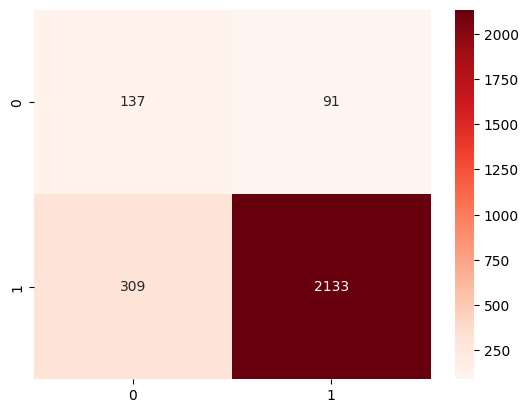

In [84]:
y_pred_yand_38 = metric(yandex, 'tiny2', 'Siuu', 0, 128)

In [85]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifierTiny64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -32.42172992981805
Val Epoch: 1, F1: 0.4915956688671047, Precision: 0.5797659116548556, Recall: 0.5944444444444444
Val Epoch: 1, F1: 0.4959679745539132, Precision: 0.5804328435452462, Recall: 0.6001638262229604 

Train Epoch: 2, Loss: -33.708545529683434
Val Epoch: 2, F1: 0.4829228952983182, Precision: 0.5845812919001296, Recall: 0.5940555555555556
Val Epoch: 2, F1: 0.48732387806667327, Precision: 0.5847438083497508, Recall: 0.5997242067427472 

Train Epoch: 3, Loss: -33.85719179704454
Val Epoch: 3, F1: 0.4790977971331081, Precision: 0.5895885452854903, Recall: 0.5929444444444445
Val Epoch: 3, F1: 0.4835633777939971, Precision: 0.5896326093379085, Recall: 0.5986562734035499 

Train Epoch: 4, Loss: -33.92815115949843
Val Epoch: 4, F1: 0.48218273061425326, Precision: 0.5777539023412265, Recall: 0.5965555555555555
Val Epoch: 4, F1: 0.48668703460296436, Precision: 0.5781094150160481, Recall: 0.6023280132772424 

Train Epoch: 5, Loss: -34.01072142389086
Val Epoch: 5, F

Accuracy:  0.7752808988764045
F1: 0.8211205451524991, Precision: 0.9109256780168656, Recall: 0.7752808988764045
F1: 0.6165056724604153, Precision: 0.6081862213465218, Recall: 0.7737618000775895 

              precision    recall  f1-score   support

          -1       0.24      0.77      0.37       228
           1       0.97      0.78      0.86      2442

    accuracy                           0.78      2670
   macro avg       0.61      0.77      0.62      2670
weighted avg       0.91      0.78      0.82      2670



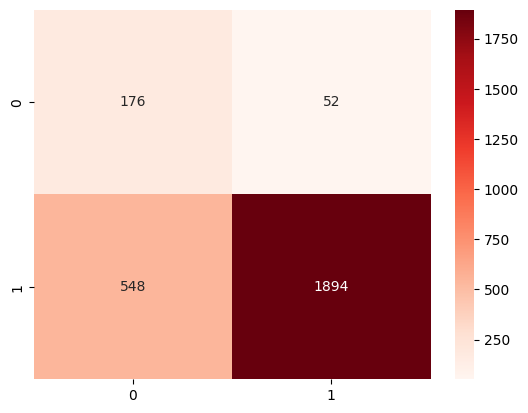

In [86]:
y_pred_yand_39 = metric(yandex, 'tiny2', 'Siuu', 0, 64)

In [87]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifierTiny64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -15.98444449159834
Val Epoch: 1, F1: 0.4851177667142276, Precision: 0.5709646119022276, Recall: 0.5866111111111111
Val Epoch: 1, F1: 0.4891038832623322, Precision: 0.5723530525770455, Recall: 0.5911093676173139 

Train Epoch: 2, Loss: -16.42526795217726
Val Epoch: 2, F1: 0.46515700730495235, Precision: 0.572015363505014, Recall: 0.5748888888888889
Val Epoch: 2, F1: 0.4688247811416453, Precision: 0.5720376248502183, Recall: 0.5798141116158004 

Train Epoch: 3, Loss: -16.474180544641282
Val Epoch: 3, F1: 0.4839172489194932, Precision: 0.5960677466849561, Recall: 0.5960555555555556
Val Epoch: 3, F1: 0.4879056905705725, Precision: 0.5964932449152328, Recall: 0.6008562623320644 

Train Epoch: 4, Loss: -16.491815239906312
Val Epoch: 4, F1: 0.4798451613150895, Precision: 0.59359815499286, Recall: 0.5933888888888889
Val Epoch: 4, F1: 0.4839062231506655, Precision: 0.5941423450578194, Recall: 0.5981776870106591 

Train Epoch: 5, Loss: -16.427340158144634
Val Epoch: 5, F1: 

Accuracy:  0.8337078651685393
F1: 0.861166445613594, Precision: 0.9086291597614948, Recall: 0.8337078651685393
F1: 0.6571620929110741, Precision: 0.6303141493104818, Recall: 0.7639499547394284 

              precision    recall  f1-score   support

          -1       0.29      0.68      0.41       228
           1       0.97      0.85      0.90      2442

    accuracy                           0.83      2670
   macro avg       0.63      0.76      0.66      2670
weighted avg       0.91      0.83      0.86      2670



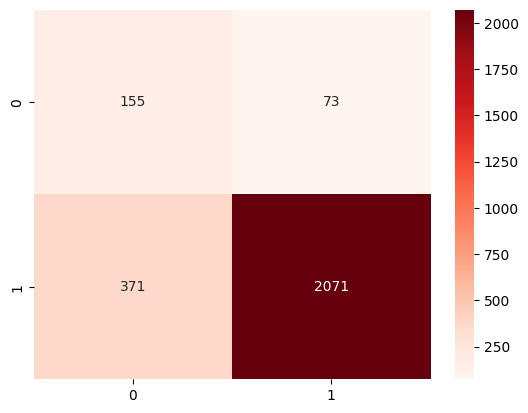

In [88]:
y_pred_yand_40 = metric(yandex, 'tiny2', 'Siuu', 0, 32)

In [89]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifierTiny64(), nn.CrossEntropyLoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: -7.708088657273186
Val Epoch: 1, F1: 0.4866357383976464, Precision: 0.5901717406247626, Recall: 0.5935
Val Epoch: 1, F1: 0.48576019398746934, Precision: 0.5905542409298944, Recall: 0.5918407262778295 

Train Epoch: 2, Loss: -7.768743047714233
Val Epoch: 2, F1: 0.4881044403625691, Precision: 0.5743820738470744, Recall: 0.5982777777777778
Val Epoch: 2, F1: 0.48722450550513213, Precision: 0.5746825302009376, Recall: 0.5966054815152676 

Train Epoch: 3, Loss: -7.882819569958581
Val Epoch: 3, F1: 0.48936122092027623, Precision: 0.6073618730365122, Recall: 0.6001666666666666
Val Epoch: 3, F1: 0.4884728278302453, Precision: 0.607812876565481, Recall: 0.5984948374009336 

Train Epoch: 4, Loss: -7.88985546180937
Val Epoch: 4, F1: 0.4856538640447735, Precision: 0.5872143278061619, Recall: 0.6
Val Epoch: 4, F1: 0.48466989341727135, Precision: 0.5873815475688481, Recall: 0.5985671830354821 

Train Epoch: 5, Loss: -7.864681272612677
Val Epoch: 5, F1: 0.48596623173548364, Preci

Accuracy:  0.7707865168539326
F1: 0.8177674311220565, Precision: 0.9094207406959642, Recall: 0.7707865168539326
F1: 0.6113869863013699, Precision: 0.6049205704715018, Recall: 0.7673283331178069 

              precision    recall  f1-score   support

          -1       0.24      0.76      0.36       228
           1       0.97      0.77      0.86      2442

    accuracy                           0.77      2670
   macro avg       0.60      0.77      0.61      2670
weighted avg       0.91      0.77      0.82      2670



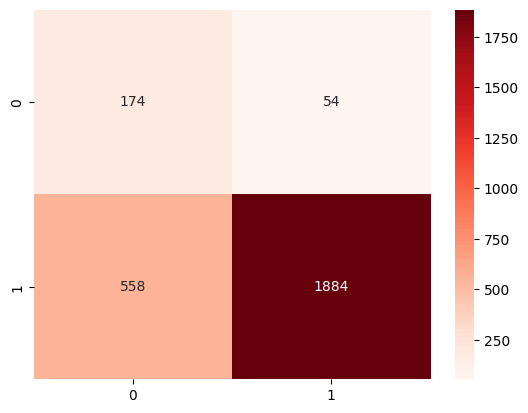

In [90]:
y_pred_yand_41 = metric(yandex, 'tiny2', 'Siuu', 0, 16)

In [91]:
model, y_pred, y_proba = train_model_2(15, 128, 0.001, SentimentClassifierTiny64(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2991239827119648
Val Epoch: 1, F1: 0.7056358320509654, Precision: 0.7326165831387912, Recall: 0.6992222222222222
Val Epoch: 1, F1: 0.7049363322527924, Precision: 0.7318606699612903, Recall: 0.6986032239855106 

Train Epoch: 2, Loss: 0.2678159914421146
Val Epoch: 2, F1: 0.7039530550069715, Precision: 0.7433296886247618, Recall: 0.6968333333333333
Val Epoch: 2, F1: 0.7032741165230855, Precision: 0.742514653702118, Recall: 0.6962995023055792 

Train Epoch: 3, Loss: 0.2636466222165109
Val Epoch: 3, F1: 0.7076658896660812, Precision: 0.735866070819881, Recall: 0.7007222222222222
Val Epoch: 3, F1: 0.706960510718435, Precision: 0.7350261103134824, Recall: 0.7001502385822027 

Train Epoch: 4, Loss: 0.2601401907777278
Val Epoch: 4, F1: 0.7116818187361912, Precision: 0.7406436429885642, Recall: 0.7049444444444445
Val Epoch: 4, F1: 0.7110040459285285, Precision: 0.7398549867595453, Recall: 0.7043851365858202 

Train Epoch: 5, Loss: 0.25802221820155424
Val Epoch: 5, F1: 0.7

Accuracy:  0.797752808988764
F1: 0.83713553948873, Precision: 0.9125479853033096, Recall: 0.797752808988764
F1: 0.635299045676404, Precision: 0.6183853459972862, Recall: 0.7820703478598215 

              precision    recall  f1-score   support

          -1       0.26      0.76      0.39       228
           1       0.97      0.80      0.88      2442

    accuracy                           0.80      2670
   macro avg       0.62      0.78      0.64      2670
weighted avg       0.91      0.80      0.84      2670



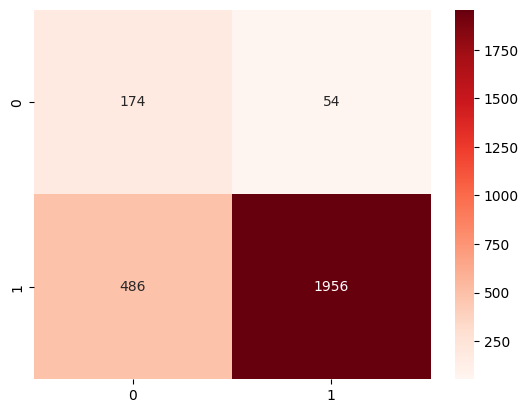

In [92]:
y_pred_yand_42 = metric(yandex, 'tiny2', 'Siuu', 0, 128)

In [93]:
model, y_pred, y_proba = train_model_2(10, 64, 0.001, SentimentClassifierTiny64(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2906741580698225
Val Epoch: 1, F1: 0.6973764452771397, Precision: 0.7435504922199345, Recall: 0.6932777777777778
Val Epoch: 1, F1: 0.6978570443863399, Precision: 0.7440740034804642, Recall: 0.6935801279023218 

Train Epoch: 2, Loss: 0.26779969251155855
Val Epoch: 2, F1: 0.7058808323004129, Precision: 0.7422090275220684, Recall: 0.699
Val Epoch: 2, F1: 0.7062703772378898, Precision: 0.7428483236271782, Recall: 0.6991156309703289 

Train Epoch: 3, Loss: 0.26235303176111646
Val Epoch: 3, F1: 0.7160293028721788, Precision: 0.7337106899733719, Recall: 0.7102222222222222
Val Epoch: 3, F1: 0.7164239799551367, Precision: 0.7343136362742295, Recall: 0.7104093886220628 

Train Epoch: 4, Loss: 0.2586227775944604
Val Epoch: 4, F1: 0.7159687380436308, Precision: 0.7406666894612457, Recall: 0.7101111111111111
Val Epoch: 4, F1: 0.7163959917393993, Precision: 0.7412568412427291, Recall: 0.7103453818530001 

Train Epoch: 5, Loss: 0.2553528414633539
Val Epoch: 5, F1: 0.7072250217

Accuracy:  0.7928838951310861
F1: 0.8331802876564319, Precision: 0.9085036917505797, Recall: 0.7928838951310861
F1: 0.626182113523913, Precision: 0.6115405482290498, Recall: 0.7654909694383378 

              precision    recall  f1-score   support

          -1       0.25      0.73      0.38       228
           1       0.97      0.80      0.88      2442

    accuracy                           0.79      2670
   macro avg       0.61      0.77      0.63      2670
weighted avg       0.91      0.79      0.83      2670



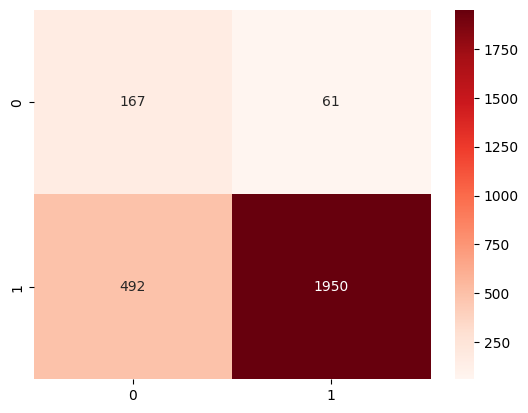

In [94]:
y_pred_yand_43 = metric(yandex, 'tiny2', 'Siuu', 0, 64)

In [95]:
model, y_pred, y_proba = train_model_2(7, 32, 0.001, SentimentClassifierTiny64(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2861462429728773
Val Epoch: 1, F1: 0.7070983350533797, Precision: 0.7188458320534705, Recall: 0.7018888888888889
Val Epoch: 1, F1: 0.7066359250245693, Precision: 0.7181420970478629, Recall: 0.7016741584763665 

Train Epoch: 2, Loss: 0.26572495754890973
Val Epoch: 2, F1: 0.7084448697347111, Precision: 0.7315512700120902, Recall: 0.701
Val Epoch: 2, F1: 0.7080396188634563, Precision: 0.7307247191423442, Recall: 0.7009990977160608 

Train Epoch: 3, Loss: 0.26094374006324345
Val Epoch: 3, F1: 0.69947143917585, Precision: 0.7506270119771405, Recall: 0.6924444444444444
Val Epoch: 3, F1: 0.6991031290999706, Precision: 0.7497445592332154, Recall: 0.692660045303133 

Train Epoch: 4, Loss: 0.2559848571005795
Val Epoch: 4, F1: 0.7082112258517946, Precision: 0.7470644318612792, Recall: 0.7020555555555555
Val Epoch: 4, F1: 0.70781852812808, Precision: 0.746260136597353, Recall: 0.7021441828182251 

Train Epoch: 5, Loss: 0.25186548242966333
Val Epoch: 5, F1: 0.711979098451408

Accuracy:  0.8322097378277153
F1: 0.8612688610577554, Precision: 0.9144504570038867, Recall: 0.8322097378277153
F1: 0.6651197792549857, Precision: 0.6368880297843088, Recall: 0.7889779731884995 

              precision    recall  f1-score   support

          -1       0.30      0.74      0.43       228
           1       0.97      0.84      0.90      2442

    accuracy                           0.83      2670
   macro avg       0.64      0.79      0.67      2670
weighted avg       0.91      0.83      0.86      2670



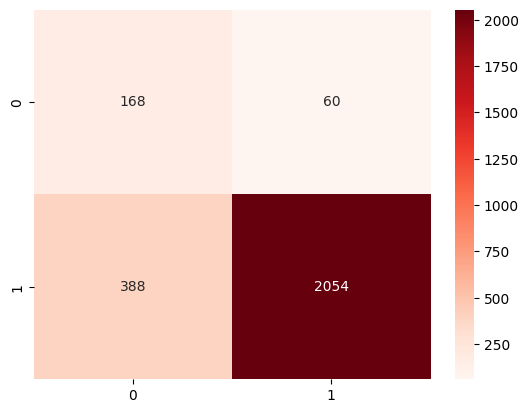

In [96]:
y_pred_yand_44 = metric(yandex, 'tiny2', 'Siuu', 0, 32)

In [97]:
model, y_pred, y_proba = train_model_2(5, 16, 0.001, SentimentClassifierTiny64(), nn.MSELoss(), False, 0.5, df=data_ru2, embed_name='tiny2', target_name='sentiment_int')

Train Epoch: 1, Loss: 0.2853477983350555
Val Epoch: 1, F1: 0.7022766187202073, Precision: 0.7292677280111719, Recall: 0.6955555555555556
Val Epoch: 1, F1: 0.7023436208752122, Precision: 0.7299684840169572, Recall: 0.6949138974144544 

Train Epoch: 2, Loss: 0.26712676838495664
Val Epoch: 2, F1: 0.7039630393977897, Precision: 0.7377081680503836, Recall: 0.6967222222222222
Val Epoch: 2, F1: 0.7040217545509432, Precision: 0.7384574457578793, Recall: 0.6959876989554926 

Train Epoch: 3, Loss: 0.26149952938738796
Val Epoch: 3, F1: 0.6992073833907905, Precision: 0.7474094929360167, Recall: 0.6928333333333333
Val Epoch: 3, F1: 0.6991129377001702, Precision: 0.7483551306997672, Recall: 0.6916387562231378 

Train Epoch: 4, Loss: 0.25724358977791334
Val Epoch: 4, F1: 0.7087783401668504, Precision: 0.7432489906792451, Recall: 0.7015
Val Epoch: 4, F1: 0.7088392520075578, Precision: 0.7440026211888876, Recall: 0.70076018638169 

Train Epoch: 5, Loss: 0.2526340300676723
Val Epoch: 5, F1: 0.7154354150

Accuracy:  0.8363295880149813
F1: 0.863401806766436, Precision: 0.9109221781365499, Recall: 0.8363295880149813
F1: 0.6629406284529887, Precision: 0.6347549632048566, Recall: 0.7733361351782404 

              precision    recall  f1-score   support

          -1       0.30      0.70      0.42       228
           1       0.97      0.85      0.90      2442

    accuracy                           0.84      2670
   macro avg       0.63      0.77      0.66      2670
weighted avg       0.91      0.84      0.86      2670



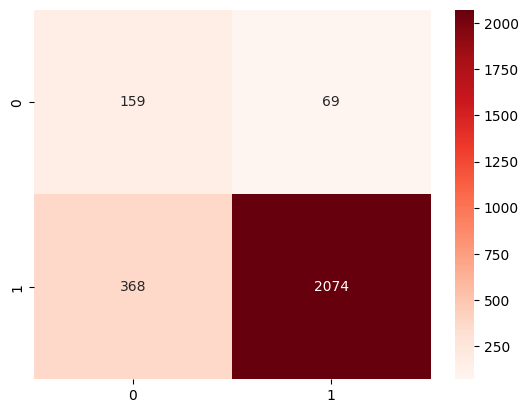

In [98]:
y_pred_yand_45 = metric(yandex, 'tiny2', 'Siuu', 0, 16)

In [99]:
df = pd.DataFrame()
df['target'] = yandex['Siuu']
for i in range(14, 46):
  df[f'model_{i}'] = globals()[f'y_pred_yand_{i}']
df.to_csv('models_14-46.csv')